In [2]:
import os
import numpy as np
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

class GANs:
    #inicialización de variables
    def __init__(self, width=28, height=28, channels=1):
        #para retornar las imágenes
        self.WIDTH = width
        self.HEIGHT = height
        self.CHANNELS = channels
        self.SHAPE = (width, height, channels)
        #self.optimizer = Adam(lr=0.0001, beta_1=0.5, decay=8e-8)
        self.optimizer = Adam(lr=0.0001, beta_1=0.5)
        self.G = self.noise_generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        #print("Compilando el generador...")
        self.D = self.discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        #print("Compilando el discriminador...")
        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()
        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        
    #Para unir el generador y el disctiminador
    def __stacked_generator_discriminator(self):
        self.D.trainable = False
        model = Sequential()
        model.add(self.G)
        model.add(self.D)
        return model
    
    #generador de ruido
    def noise_generator(self):
        model = Sequential()
        model.add(Dense(256, input_shape=(100,)))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        #model.add(Dropout(0.1))
        model.add(BatchNormalization(momentum=0.8)) #normalización de las capas anteriores
        model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        #model.add(Dropout(0.1))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.WIDTH  * self.HEIGHT * self.CHANNELS, activation='tanh'))
        model.add(Reshape((self.WIDTH, self.HEIGHT, self.CHANNELS)))
        return model

    #Discriminador 
    def discriminator(self):    
        model = Sequential()
        model.add(Flatten(input_shape=self.SHAPE))
        model.add(Dense((self.WIDTH * self.HEIGHT * self.CHANNELS), input_shape=self.SHAPE))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.int64((self.WIDTH * self.HEIGHT * self.CHANNELS)/2)))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.1))
        model.add(Dense(1, activation='sigmoid'))
        #model.summary()
        return model
    
    #Entrenar la GANs
    def train(self, X_train, epochs, batch):
        ## train discriminator
        for cnt in range(epochs):
            random_index = np.random.randint(0, len(X_train) - np.int64(batch/2))
            #print(random_index)
            legit_images = X_train[random_index:random_index + np.int64(batch/2)].reshape(np.int64(batch/2),
                                                                                            self.WIDTH,
                                                                                            self.HEIGHT,
                                                                                            self.CHANNELS)
            gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
            #print(gen_noise.shape)
            syntetic_images = self.G.predict(gen_noise)
            #print(legit_images.shape, syntetic_images.shape)
            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)),
                                               np.zeros((np.int64(batch/2), 1))))

            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)


            # train generator
            noise = np.random.normal(0, 1, (batch, 100))
            y_mislabled = np.ones((batch, 1))

            g_loss = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)

            print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0],
                                                                                           g_loss))
        return None

    #predict
    def predict(self, noise):
        imgs = self.G.predict(noise)
        return imgs

In [6]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

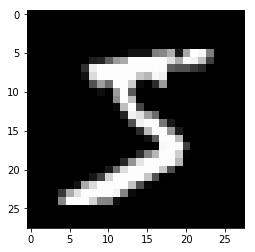

In [25]:
plt.imshow(X_train[0], cmap="gray")

In [26]:
X_train.shape

(60000, 28, 28)

In [39]:
m = 255/2
X_train = (X_train.astype(np.float32) - m) / m
X_train = np.expand_dims(X_train, axis=3)

In [40]:
obj = GANs()
obj.train(X_train, epochs=10000, batch=128)


/home/ejrueda/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator :: d_loss: 1.261303], [ Generator :: loss: 1.100127]
epoch: 1, [Discriminator :: d_loss: 0.718487], [ Generator :: loss: 1.002391]
epoch: 2, [Discriminator :: d_loss: 0.409594], [ Generator :: loss: 1.011608]
epoch: 3, [Discriminator :: d_loss: 0.325176], [ Generator :: loss: 1.039338]
epoch: 4, [Discriminator :: d_loss: 0.279728], [ Generator :: loss: 1.052287]
epoch: 5, [Discriminator :: d_loss: 0.247552], [ Generator :: loss: 1.146028]
epoch: 6, [Discriminator :: d_loss: 0.230576], [ Generator :: loss: 1.207674]
epoch: 7, [Discriminator :: d_loss: 0.214193], [ Generator :: loss: 1.270219]
epoch: 8, [Discriminator :: d_loss: 0.188863], [ Generator :: loss: 1.368383]
epoch: 9, [Discriminator :: d_loss: 0.182781], [ Generator :: loss: 1.442609]
epoch: 10, [Discriminator :: d_loss: 0.174792], [ Generator :: loss: 1.541998]
epoch: 11, [Discriminator :: d_loss: 0.155333], [ Generator :: loss: 1.554674]
epoch: 12, [Discriminator :: d_loss: 0.152527], [ Generator ::

epoch: 104, [Discriminator :: d_loss: 0.023625], [ Generator :: loss: 3.911066]
epoch: 105, [Discriminator :: d_loss: 0.018887], [ Generator :: loss: 3.882941]
epoch: 106, [Discriminator :: d_loss: 0.030155], [ Generator :: loss: 3.844814]
epoch: 107, [Discriminator :: d_loss: 0.016670], [ Generator :: loss: 3.917916]
epoch: 108, [Discriminator :: d_loss: 0.018428], [ Generator :: loss: 3.843985]
epoch: 109, [Discriminator :: d_loss: 0.017961], [ Generator :: loss: 3.843042]
epoch: 110, [Discriminator :: d_loss: 0.018278], [ Generator :: loss: 3.886509]
epoch: 111, [Discriminator :: d_loss: 0.024511], [ Generator :: loss: 3.837320]
epoch: 112, [Discriminator :: d_loss: 0.019732], [ Generator :: loss: 3.917614]
epoch: 113, [Discriminator :: d_loss: 0.018999], [ Generator :: loss: 3.906102]
epoch: 114, [Discriminator :: d_loss: 0.016588], [ Generator :: loss: 3.899540]
epoch: 115, [Discriminator :: d_loss: 0.023580], [ Generator :: loss: 3.870620]
epoch: 116, [Discriminator :: d_loss: 0.

epoch: 208, [Discriminator :: d_loss: 0.148406], [ Generator :: loss: 3.090705]
epoch: 209, [Discriminator :: d_loss: 0.076520], [ Generator :: loss: 3.290699]
epoch: 210, [Discriminator :: d_loss: 0.093726], [ Generator :: loss: 3.627298]
epoch: 211, [Discriminator :: d_loss: 0.119124], [ Generator :: loss: 2.792778]
epoch: 212, [Discriminator :: d_loss: 0.128259], [ Generator :: loss: 2.836272]
epoch: 213, [Discriminator :: d_loss: 0.105175], [ Generator :: loss: 3.407697]
epoch: 214, [Discriminator :: d_loss: 0.060358], [ Generator :: loss: 3.569309]
epoch: 215, [Discriminator :: d_loss: 0.088392], [ Generator :: loss: 2.998677]
epoch: 216, [Discriminator :: d_loss: 0.110665], [ Generator :: loss: 3.056376]
epoch: 217, [Discriminator :: d_loss: 0.099706], [ Generator :: loss: 3.735647]
epoch: 218, [Discriminator :: d_loss: 0.093686], [ Generator :: loss: 2.696677]
epoch: 219, [Discriminator :: d_loss: 0.161432], [ Generator :: loss: 3.031806]
epoch: 220, [Discriminator :: d_loss: 0.

epoch: 311, [Discriminator :: d_loss: 1.091197], [ Generator :: loss: 0.611293]
epoch: 312, [Discriminator :: d_loss: 0.946220], [ Generator :: loss: 1.780468]
epoch: 313, [Discriminator :: d_loss: 0.321188], [ Generator :: loss: 4.373901]
epoch: 314, [Discriminator :: d_loss: 0.292242], [ Generator :: loss: 3.045644]
epoch: 315, [Discriminator :: d_loss: 0.164989], [ Generator :: loss: 2.143477]
epoch: 316, [Discriminator :: d_loss: 0.227507], [ Generator :: loss: 2.106111]
epoch: 317, [Discriminator :: d_loss: 0.274708], [ Generator :: loss: 2.533328]
epoch: 318, [Discriminator :: d_loss: 0.206907], [ Generator :: loss: 2.040785]
epoch: 319, [Discriminator :: d_loss: 0.247307], [ Generator :: loss: 2.093119]
epoch: 320, [Discriminator :: d_loss: 0.231459], [ Generator :: loss: 2.089609]
epoch: 321, [Discriminator :: d_loss: 0.286211], [ Generator :: loss: 1.865832]
epoch: 322, [Discriminator :: d_loss: 0.234417], [ Generator :: loss: 1.806823]
epoch: 323, [Discriminator :: d_loss: 0.

epoch: 414, [Discriminator :: d_loss: 0.535134], [ Generator :: loss: 1.091018]
epoch: 415, [Discriminator :: d_loss: 0.574947], [ Generator :: loss: 0.554251]
epoch: 416, [Discriminator :: d_loss: 0.602069], [ Generator :: loss: 0.970684]
epoch: 417, [Discriminator :: d_loss: 0.579955], [ Generator :: loss: 0.840882]
epoch: 418, [Discriminator :: d_loss: 0.581641], [ Generator :: loss: 0.618738]
epoch: 419, [Discriminator :: d_loss: 0.556821], [ Generator :: loss: 1.149975]
epoch: 420, [Discriminator :: d_loss: 0.535002], [ Generator :: loss: 0.573614]
epoch: 421, [Discriminator :: d_loss: 0.574715], [ Generator :: loss: 0.979967]
epoch: 422, [Discriminator :: d_loss: 0.568885], [ Generator :: loss: 0.659065]
epoch: 423, [Discriminator :: d_loss: 0.551102], [ Generator :: loss: 0.987192]
epoch: 424, [Discriminator :: d_loss: 0.507158], [ Generator :: loss: 0.741577]
epoch: 425, [Discriminator :: d_loss: 0.468169], [ Generator :: loss: 0.913453]
epoch: 426, [Discriminator :: d_loss: 0.

epoch: 519, [Discriminator :: d_loss: 0.475963], [ Generator :: loss: 1.192825]
epoch: 520, [Discriminator :: d_loss: 0.571189], [ Generator :: loss: 0.312445]
epoch: 521, [Discriminator :: d_loss: 0.696530], [ Generator :: loss: 1.317227]
epoch: 522, [Discriminator :: d_loss: 0.524872], [ Generator :: loss: 0.548190]
epoch: 523, [Discriminator :: d_loss: 0.553247], [ Generator :: loss: 1.065241]
epoch: 524, [Discriminator :: d_loss: 0.438940], [ Generator :: loss: 0.840436]
epoch: 525, [Discriminator :: d_loss: 0.590019], [ Generator :: loss: 0.512469]
epoch: 526, [Discriminator :: d_loss: 0.583378], [ Generator :: loss: 1.338498]
epoch: 527, [Discriminator :: d_loss: 0.548151], [ Generator :: loss: 0.379354]
epoch: 528, [Discriminator :: d_loss: 0.650348], [ Generator :: loss: 1.256800]
epoch: 529, [Discriminator :: d_loss: 0.519153], [ Generator :: loss: 0.593045]
epoch: 530, [Discriminator :: d_loss: 0.513808], [ Generator :: loss: 1.048652]
epoch: 531, [Discriminator :: d_loss: 0.

epoch: 624, [Discriminator :: d_loss: 0.495374], [ Generator :: loss: 0.554590]
epoch: 625, [Discriminator :: d_loss: 0.547709], [ Generator :: loss: 1.308607]
epoch: 626, [Discriminator :: d_loss: 0.553589], [ Generator :: loss: 0.480269]
epoch: 627, [Discriminator :: d_loss: 0.573095], [ Generator :: loss: 1.277997]
epoch: 628, [Discriminator :: d_loss: 0.498589], [ Generator :: loss: 0.635113]
epoch: 629, [Discriminator :: d_loss: 0.499313], [ Generator :: loss: 1.193066]
epoch: 630, [Discriminator :: d_loss: 0.492048], [ Generator :: loss: 0.671939]
epoch: 631, [Discriminator :: d_loss: 0.486400], [ Generator :: loss: 1.219755]
epoch: 632, [Discriminator :: d_loss: 0.500127], [ Generator :: loss: 0.552803]
epoch: 633, [Discriminator :: d_loss: 0.533330], [ Generator :: loss: 1.413536]
epoch: 634, [Discriminator :: d_loss: 0.588914], [ Generator :: loss: 0.376598]
epoch: 635, [Discriminator :: d_loss: 0.653323], [ Generator :: loss: 1.329364]
epoch: 636, [Discriminator :: d_loss: 0.

epoch: 729, [Discriminator :: d_loss: 0.450411], [ Generator :: loss: 1.218281]
epoch: 730, [Discriminator :: d_loss: 0.509921], [ Generator :: loss: 0.477229]
epoch: 731, [Discriminator :: d_loss: 0.611890], [ Generator :: loss: 1.299761]
epoch: 732, [Discriminator :: d_loss: 0.530595], [ Generator :: loss: 0.585448]
epoch: 733, [Discriminator :: d_loss: 0.508488], [ Generator :: loss: 1.514385]
epoch: 734, [Discriminator :: d_loss: 0.596436], [ Generator :: loss: 0.348283]
epoch: 735, [Discriminator :: d_loss: 0.665679], [ Generator :: loss: 1.618966]
epoch: 736, [Discriminator :: d_loss: 0.620419], [ Generator :: loss: 0.368274]
epoch: 737, [Discriminator :: d_loss: 0.683015], [ Generator :: loss: 1.377131]
epoch: 738, [Discriminator :: d_loss: 0.512601], [ Generator :: loss: 0.584721]
epoch: 739, [Discriminator :: d_loss: 0.531896], [ Generator :: loss: 1.178090]
epoch: 740, [Discriminator :: d_loss: 0.499215], [ Generator :: loss: 0.720358]
epoch: 741, [Discriminator :: d_loss: 0.

epoch: 834, [Discriminator :: d_loss: 0.623283], [ Generator :: loss: 1.535126]
epoch: 835, [Discriminator :: d_loss: 0.591610], [ Generator :: loss: 0.418741]
epoch: 836, [Discriminator :: d_loss: 0.630256], [ Generator :: loss: 1.437701]
epoch: 837, [Discriminator :: d_loss: 0.704265], [ Generator :: loss: 0.557345]
epoch: 838, [Discriminator :: d_loss: 0.579536], [ Generator :: loss: 1.495118]
epoch: 839, [Discriminator :: d_loss: 0.617454], [ Generator :: loss: 0.446064]
epoch: 840, [Discriminator :: d_loss: 0.628229], [ Generator :: loss: 1.538876]
epoch: 841, [Discriminator :: d_loss: 0.567114], [ Generator :: loss: 0.568888]
epoch: 842, [Discriminator :: d_loss: 0.564579], [ Generator :: loss: 1.205185]
epoch: 843, [Discriminator :: d_loss: 0.558575], [ Generator :: loss: 0.569225]
epoch: 844, [Discriminator :: d_loss: 0.560001], [ Generator :: loss: 1.287784]
epoch: 845, [Discriminator :: d_loss: 0.571274], [ Generator :: loss: 0.544410]
epoch: 846, [Discriminator :: d_loss: 0.

epoch: 938, [Discriminator :: d_loss: 0.577531], [ Generator :: loss: 0.656763]
epoch: 939, [Discriminator :: d_loss: 0.537806], [ Generator :: loss: 1.186756]
epoch: 940, [Discriminator :: d_loss: 0.522960], [ Generator :: loss: 0.792524]
epoch: 941, [Discriminator :: d_loss: 0.503944], [ Generator :: loss: 1.045767]
epoch: 942, [Discriminator :: d_loss: 0.528662], [ Generator :: loss: 0.699033]
epoch: 943, [Discriminator :: d_loss: 0.530413], [ Generator :: loss: 1.125648]
epoch: 944, [Discriminator :: d_loss: 0.517443], [ Generator :: loss: 0.727353]
epoch: 945, [Discriminator :: d_loss: 0.521714], [ Generator :: loss: 1.084699]
epoch: 946, [Discriminator :: d_loss: 0.516860], [ Generator :: loss: 0.792447]
epoch: 947, [Discriminator :: d_loss: 0.524811], [ Generator :: loss: 1.229366]
epoch: 948, [Discriminator :: d_loss: 0.531301], [ Generator :: loss: 0.630466]
epoch: 949, [Discriminator :: d_loss: 0.562145], [ Generator :: loss: 1.215547]
epoch: 950, [Discriminator :: d_loss: 0.

epoch: 1041, [Discriminator :: d_loss: 0.555729], [ Generator :: loss: 1.158842]
epoch: 1042, [Discriminator :: d_loss: 0.533976], [ Generator :: loss: 0.698133]
epoch: 1043, [Discriminator :: d_loss: 0.541091], [ Generator :: loss: 1.101162]
epoch: 1044, [Discriminator :: d_loss: 0.540985], [ Generator :: loss: 0.629550]
epoch: 1045, [Discriminator :: d_loss: 0.565413], [ Generator :: loss: 1.394748]
epoch: 1046, [Discriminator :: d_loss: 0.559219], [ Generator :: loss: 0.505985]
epoch: 1047, [Discriminator :: d_loss: 0.599468], [ Generator :: loss: 1.289178]
epoch: 1048, [Discriminator :: d_loss: 0.598856], [ Generator :: loss: 0.517660]
epoch: 1049, [Discriminator :: d_loss: 0.604868], [ Generator :: loss: 1.443067]
epoch: 1050, [Discriminator :: d_loss: 0.602497], [ Generator :: loss: 0.492058]
epoch: 1051, [Discriminator :: d_loss: 0.575052], [ Generator :: loss: 1.471836]
epoch: 1052, [Discriminator :: d_loss: 0.584873], [ Generator :: loss: 0.507410]
epoch: 1053, [Discriminator 

epoch: 1144, [Discriminator :: d_loss: 0.525695], [ Generator :: loss: 1.056032]
epoch: 1145, [Discriminator :: d_loss: 0.479912], [ Generator :: loss: 0.994811]
epoch: 1146, [Discriminator :: d_loss: 0.465080], [ Generator :: loss: 0.990461]
epoch: 1147, [Discriminator :: d_loss: 0.494254], [ Generator :: loss: 0.947309]
epoch: 1148, [Discriminator :: d_loss: 0.486139], [ Generator :: loss: 0.999312]
epoch: 1149, [Discriminator :: d_loss: 0.503865], [ Generator :: loss: 0.811740]
epoch: 1150, [Discriminator :: d_loss: 0.485435], [ Generator :: loss: 1.334630]
epoch: 1151, [Discriminator :: d_loss: 0.515883], [ Generator :: loss: 0.634356]
epoch: 1152, [Discriminator :: d_loss: 0.543229], [ Generator :: loss: 1.571078]
epoch: 1153, [Discriminator :: d_loss: 0.558149], [ Generator :: loss: 0.593999]
epoch: 1154, [Discriminator :: d_loss: 0.531024], [ Generator :: loss: 1.466138]
epoch: 1155, [Discriminator :: d_loss: 0.583728], [ Generator :: loss: 0.526861]
epoch: 1156, [Discriminator 

epoch: 1248, [Discriminator :: d_loss: 0.756809], [ Generator :: loss: 1.830737]
epoch: 1249, [Discriminator :: d_loss: 0.722239], [ Generator :: loss: 0.386973]
epoch: 1250, [Discriminator :: d_loss: 0.674399], [ Generator :: loss: 1.373115]
epoch: 1251, [Discriminator :: d_loss: 0.629981], [ Generator :: loss: 0.813221]
epoch: 1252, [Discriminator :: d_loss: 0.610752], [ Generator :: loss: 0.828131]
epoch: 1253, [Discriminator :: d_loss: 0.506214], [ Generator :: loss: 1.476789]
epoch: 1254, [Discriminator :: d_loss: 0.618450], [ Generator :: loss: 0.393243]
epoch: 1255, [Discriminator :: d_loss: 0.746631], [ Generator :: loss: 1.622188]
epoch: 1256, [Discriminator :: d_loss: 0.678853], [ Generator :: loss: 0.455688]
epoch: 1257, [Discriminator :: d_loss: 0.662487], [ Generator :: loss: 1.440207]
epoch: 1258, [Discriminator :: d_loss: 0.669766], [ Generator :: loss: 0.451115]
epoch: 1259, [Discriminator :: d_loss: 0.656894], [ Generator :: loss: 1.501301]
epoch: 1260, [Discriminator 

epoch: 1352, [Discriminator :: d_loss: 0.702144], [ Generator :: loss: 1.743760]
epoch: 1353, [Discriminator :: d_loss: 0.646424], [ Generator :: loss: 0.551683]
epoch: 1354, [Discriminator :: d_loss: 0.558893], [ Generator :: loss: 1.375074]
epoch: 1355, [Discriminator :: d_loss: 0.612188], [ Generator :: loss: 0.599832]
epoch: 1356, [Discriminator :: d_loss: 0.650626], [ Generator :: loss: 1.286182]
epoch: 1357, [Discriminator :: d_loss: 0.555465], [ Generator :: loss: 0.805362]
epoch: 1358, [Discriminator :: d_loss: 0.602083], [ Generator :: loss: 0.732991]
epoch: 1359, [Discriminator :: d_loss: 0.559443], [ Generator :: loss: 1.295141]
epoch: 1360, [Discriminator :: d_loss: 0.560281], [ Generator :: loss: 0.525889]
epoch: 1361, [Discriminator :: d_loss: 0.609726], [ Generator :: loss: 1.476497]
epoch: 1362, [Discriminator :: d_loss: 0.623247], [ Generator :: loss: 0.600874]
epoch: 1363, [Discriminator :: d_loss: 0.623215], [ Generator :: loss: 1.271962]
epoch: 1364, [Discriminator 

epoch: 1456, [Discriminator :: d_loss: 0.553133], [ Generator :: loss: 0.936788]
epoch: 1457, [Discriminator :: d_loss: 0.572156], [ Generator :: loss: 0.819883]
epoch: 1458, [Discriminator :: d_loss: 0.580791], [ Generator :: loss: 0.939087]
epoch: 1459, [Discriminator :: d_loss: 0.585532], [ Generator :: loss: 0.899817]
epoch: 1460, [Discriminator :: d_loss: 0.552594], [ Generator :: loss: 0.973901]
epoch: 1461, [Discriminator :: d_loss: 0.618187], [ Generator :: loss: 0.648450]
epoch: 1462, [Discriminator :: d_loss: 0.597342], [ Generator :: loss: 1.361502]
epoch: 1463, [Discriminator :: d_loss: 0.667375], [ Generator :: loss: 0.341020]
epoch: 1464, [Discriminator :: d_loss: 0.750548], [ Generator :: loss: 1.802527]
epoch: 1465, [Discriminator :: d_loss: 0.792035], [ Generator :: loss: 0.381987]
epoch: 1466, [Discriminator :: d_loss: 0.711361], [ Generator :: loss: 1.354010]
epoch: 1467, [Discriminator :: d_loss: 0.651061], [ Generator :: loss: 0.534919]
epoch: 1468, [Discriminator 

epoch: 1560, [Discriminator :: d_loss: 0.617292], [ Generator :: loss: 0.664594]
epoch: 1561, [Discriminator :: d_loss: 0.579709], [ Generator :: loss: 1.119184]
epoch: 1562, [Discriminator :: d_loss: 0.567203], [ Generator :: loss: 0.789061]
epoch: 1563, [Discriminator :: d_loss: 0.574889], [ Generator :: loss: 1.039377]
epoch: 1564, [Discriminator :: d_loss: 0.552362], [ Generator :: loss: 0.724883]
epoch: 1565, [Discriminator :: d_loss: 0.594923], [ Generator :: loss: 1.188872]
epoch: 1566, [Discriminator :: d_loss: 0.586220], [ Generator :: loss: 0.597471]
epoch: 1567, [Discriminator :: d_loss: 0.608658], [ Generator :: loss: 1.257724]
epoch: 1568, [Discriminator :: d_loss: 0.553712], [ Generator :: loss: 0.700033]
epoch: 1569, [Discriminator :: d_loss: 0.568982], [ Generator :: loss: 1.137095]
epoch: 1570, [Discriminator :: d_loss: 0.570843], [ Generator :: loss: 0.761689]
epoch: 1571, [Discriminator :: d_loss: 0.594796], [ Generator :: loss: 1.102997]
epoch: 1572, [Discriminator 

epoch: 1665, [Discriminator :: d_loss: 0.550689], [ Generator :: loss: 0.898205]
epoch: 1666, [Discriminator :: d_loss: 0.529651], [ Generator :: loss: 0.966323]
epoch: 1667, [Discriminator :: d_loss: 0.558095], [ Generator :: loss: 0.803797]
epoch: 1668, [Discriminator :: d_loss: 0.558534], [ Generator :: loss: 1.059491]
epoch: 1669, [Discriminator :: d_loss: 0.603172], [ Generator :: loss: 0.625308]
epoch: 1670, [Discriminator :: d_loss: 0.575818], [ Generator :: loss: 1.379600]
epoch: 1671, [Discriminator :: d_loss: 0.692778], [ Generator :: loss: 0.398510]
epoch: 1672, [Discriminator :: d_loss: 0.708354], [ Generator :: loss: 1.505552]
epoch: 1673, [Discriminator :: d_loss: 0.728137], [ Generator :: loss: 0.427661]
epoch: 1674, [Discriminator :: d_loss: 0.690620], [ Generator :: loss: 1.289496]
epoch: 1675, [Discriminator :: d_loss: 0.614295], [ Generator :: loss: 0.743135]
epoch: 1676, [Discriminator :: d_loss: 0.573439], [ Generator :: loss: 0.937737]
epoch: 1677, [Discriminator 

epoch: 1769, [Discriminator :: d_loss: 0.612257], [ Generator :: loss: 0.549371]
epoch: 1770, [Discriminator :: d_loss: 0.654624], [ Generator :: loss: 1.238251]
epoch: 1771, [Discriminator :: d_loss: 0.590760], [ Generator :: loss: 0.718002]
epoch: 1772, [Discriminator :: d_loss: 0.593424], [ Generator :: loss: 1.019363]
epoch: 1773, [Discriminator :: d_loss: 0.583972], [ Generator :: loss: 0.790061]
epoch: 1774, [Discriminator :: d_loss: 0.606857], [ Generator :: loss: 1.064848]
epoch: 1775, [Discriminator :: d_loss: 0.567401], [ Generator :: loss: 0.868747]
epoch: 1776, [Discriminator :: d_loss: 0.567210], [ Generator :: loss: 0.934366]
epoch: 1777, [Discriminator :: d_loss: 0.575360], [ Generator :: loss: 0.860666]
epoch: 1778, [Discriminator :: d_loss: 0.582767], [ Generator :: loss: 0.850144]
epoch: 1779, [Discriminator :: d_loss: 0.629003], [ Generator :: loss: 0.856454]
epoch: 1780, [Discriminator :: d_loss: 0.597925], [ Generator :: loss: 1.039812]
epoch: 1781, [Discriminator 

epoch: 1872, [Discriminator :: d_loss: 0.534631], [ Generator :: loss: 0.932651]
epoch: 1873, [Discriminator :: d_loss: 0.583689], [ Generator :: loss: 0.737675]
epoch: 1874, [Discriminator :: d_loss: 0.527600], [ Generator :: loss: 1.319154]
epoch: 1875, [Discriminator :: d_loss: 0.624850], [ Generator :: loss: 0.530328]
epoch: 1876, [Discriminator :: d_loss: 0.609521], [ Generator :: loss: 1.594528]
epoch: 1877, [Discriminator :: d_loss: 0.661289], [ Generator :: loss: 0.373877]
epoch: 1878, [Discriminator :: d_loss: 0.701965], [ Generator :: loss: 1.540959]
epoch: 1879, [Discriminator :: d_loss: 0.645739], [ Generator :: loss: 0.636925]
epoch: 1880, [Discriminator :: d_loss: 0.558691], [ Generator :: loss: 1.304686]
epoch: 1881, [Discriminator :: d_loss: 0.572734], [ Generator :: loss: 0.734109]
epoch: 1882, [Discriminator :: d_loss: 0.565514], [ Generator :: loss: 1.312533]
epoch: 1883, [Discriminator :: d_loss: 0.482889], [ Generator :: loss: 0.932671]
epoch: 1884, [Discriminator 

epoch: 1976, [Discriminator :: d_loss: 0.593814], [ Generator :: loss: 0.695633]
epoch: 1977, [Discriminator :: d_loss: 0.579268], [ Generator :: loss: 1.078707]
epoch: 1978, [Discriminator :: d_loss: 0.559634], [ Generator :: loss: 0.841473]
epoch: 1979, [Discriminator :: d_loss: 0.558452], [ Generator :: loss: 0.890296]
epoch: 1980, [Discriminator :: d_loss: 0.550363], [ Generator :: loss: 1.107791]
epoch: 1981, [Discriminator :: d_loss: 0.541189], [ Generator :: loss: 0.899167]
epoch: 1982, [Discriminator :: d_loss: 0.555597], [ Generator :: loss: 0.941463]
epoch: 1983, [Discriminator :: d_loss: 0.552761], [ Generator :: loss: 0.992052]
epoch: 1984, [Discriminator :: d_loss: 0.534649], [ Generator :: loss: 0.959684]
epoch: 1985, [Discriminator :: d_loss: 0.574065], [ Generator :: loss: 0.733106]
epoch: 1986, [Discriminator :: d_loss: 0.520330], [ Generator :: loss: 1.415346]
epoch: 1987, [Discriminator :: d_loss: 0.657891], [ Generator :: loss: 0.438184]
epoch: 1988, [Discriminator 

epoch: 2079, [Discriminator :: d_loss: 0.575920], [ Generator :: loss: 1.358961]
epoch: 2080, [Discriminator :: d_loss: 0.584351], [ Generator :: loss: 0.656199]
epoch: 2081, [Discriminator :: d_loss: 0.551457], [ Generator :: loss: 1.354726]
epoch: 2082, [Discriminator :: d_loss: 0.623999], [ Generator :: loss: 0.557011]
epoch: 2083, [Discriminator :: d_loss: 0.590384], [ Generator :: loss: 1.337433]
epoch: 2084, [Discriminator :: d_loss: 0.578283], [ Generator :: loss: 0.644582]
epoch: 2085, [Discriminator :: d_loss: 0.556548], [ Generator :: loss: 1.219614]
epoch: 2086, [Discriminator :: d_loss: 0.606888], [ Generator :: loss: 0.582057]
epoch: 2087, [Discriminator :: d_loss: 0.605794], [ Generator :: loss: 1.278493]
epoch: 2088, [Discriminator :: d_loss: 0.566581], [ Generator :: loss: 0.781721]
epoch: 2089, [Discriminator :: d_loss: 0.540867], [ Generator :: loss: 1.126504]
epoch: 2090, [Discriminator :: d_loss: 0.547376], [ Generator :: loss: 0.805210]
epoch: 2091, [Discriminator 

epoch: 2182, [Discriminator :: d_loss: 0.555754], [ Generator :: loss: 0.659051]
epoch: 2183, [Discriminator :: d_loss: 0.576816], [ Generator :: loss: 1.195468]
epoch: 2184, [Discriminator :: d_loss: 0.512497], [ Generator :: loss: 0.881722]
epoch: 2185, [Discriminator :: d_loss: 0.540631], [ Generator :: loss: 1.032943]
epoch: 2186, [Discriminator :: d_loss: 0.552898], [ Generator :: loss: 0.852165]
epoch: 2187, [Discriminator :: d_loss: 0.528269], [ Generator :: loss: 1.275558]
epoch: 2188, [Discriminator :: d_loss: 0.550186], [ Generator :: loss: 0.606055]
epoch: 2189, [Discriminator :: d_loss: 0.602636], [ Generator :: loss: 1.490526]
epoch: 2190, [Discriminator :: d_loss: 0.605463], [ Generator :: loss: 0.565099]
epoch: 2191, [Discriminator :: d_loss: 0.607277], [ Generator :: loss: 1.456149]
epoch: 2192, [Discriminator :: d_loss: 0.576217], [ Generator :: loss: 0.674955]
epoch: 2193, [Discriminator :: d_loss: 0.559457], [ Generator :: loss: 1.189959]
epoch: 2194, [Discriminator 

epoch: 2286, [Discriminator :: d_loss: 0.547281], [ Generator :: loss: 0.872139]
epoch: 2287, [Discriminator :: d_loss: 0.563139], [ Generator :: loss: 0.920530]
epoch: 2288, [Discriminator :: d_loss: 0.586256], [ Generator :: loss: 0.809753]
epoch: 2289, [Discriminator :: d_loss: 0.567353], [ Generator :: loss: 1.089504]
epoch: 2290, [Discriminator :: d_loss: 0.581835], [ Generator :: loss: 0.803830]
epoch: 2291, [Discriminator :: d_loss: 0.581960], [ Generator :: loss: 1.078243]
epoch: 2292, [Discriminator :: d_loss: 0.547906], [ Generator :: loss: 0.831619]
epoch: 2293, [Discriminator :: d_loss: 0.567606], [ Generator :: loss: 1.096991]
epoch: 2294, [Discriminator :: d_loss: 0.528724], [ Generator :: loss: 0.867035]
epoch: 2295, [Discriminator :: d_loss: 0.604285], [ Generator :: loss: 1.060538]
epoch: 2296, [Discriminator :: d_loss: 0.569998], [ Generator :: loss: 0.891161]
epoch: 2297, [Discriminator :: d_loss: 0.586074], [ Generator :: loss: 1.029234]
epoch: 2298, [Discriminator 

epoch: 2388, [Discriminator :: d_loss: 0.564487], [ Generator :: loss: 0.618919]
epoch: 2389, [Discriminator :: d_loss: 0.589575], [ Generator :: loss: 1.427276]
epoch: 2390, [Discriminator :: d_loss: 0.532218], [ Generator :: loss: 0.796131]
epoch: 2391, [Discriminator :: d_loss: 0.533490], [ Generator :: loss: 1.062785]
epoch: 2392, [Discriminator :: d_loss: 0.560954], [ Generator :: loss: 0.996433]
epoch: 2393, [Discriminator :: d_loss: 0.582197], [ Generator :: loss: 1.004742]
epoch: 2394, [Discriminator :: d_loss: 0.580188], [ Generator :: loss: 0.798554]
epoch: 2395, [Discriminator :: d_loss: 0.507189], [ Generator :: loss: 1.593811]
epoch: 2396, [Discriminator :: d_loss: 0.702387], [ Generator :: loss: 0.413087]
epoch: 2397, [Discriminator :: d_loss: 0.685477], [ Generator :: loss: 1.871776]
epoch: 2398, [Discriminator :: d_loss: 0.607866], [ Generator :: loss: 0.894722]
epoch: 2399, [Discriminator :: d_loss: 0.556655], [ Generator :: loss: 0.674193]
epoch: 2400, [Discriminator 

epoch: 2492, [Discriminator :: d_loss: 0.549385], [ Generator :: loss: 0.838307]
epoch: 2493, [Discriminator :: d_loss: 0.513144], [ Generator :: loss: 1.304982]
epoch: 2494, [Discriminator :: d_loss: 0.571575], [ Generator :: loss: 0.662578]
epoch: 2495, [Discriminator :: d_loss: 0.566923], [ Generator :: loss: 1.321469]
epoch: 2496, [Discriminator :: d_loss: 0.612783], [ Generator :: loss: 0.567452]
epoch: 2497, [Discriminator :: d_loss: 0.616628], [ Generator :: loss: 1.304795]
epoch: 2498, [Discriminator :: d_loss: 0.651471], [ Generator :: loss: 0.551104]
epoch: 2499, [Discriminator :: d_loss: 0.593465], [ Generator :: loss: 1.545715]
epoch: 2500, [Discriminator :: d_loss: 0.595841], [ Generator :: loss: 0.633828]
epoch: 2501, [Discriminator :: d_loss: 0.624739], [ Generator :: loss: 1.100260]
epoch: 2502, [Discriminator :: d_loss: 0.536978], [ Generator :: loss: 0.988004]
epoch: 2503, [Discriminator :: d_loss: 0.519431], [ Generator :: loss: 0.855126]
epoch: 2504, [Discriminator 

epoch: 2595, [Discriminator :: d_loss: 0.628697], [ Generator :: loss: 1.293564]
epoch: 2596, [Discriminator :: d_loss: 0.573718], [ Generator :: loss: 0.671586]
epoch: 2597, [Discriminator :: d_loss: 0.557824], [ Generator :: loss: 1.138919]
epoch: 2598, [Discriminator :: d_loss: 0.573975], [ Generator :: loss: 0.936816]
epoch: 2599, [Discriminator :: d_loss: 0.588606], [ Generator :: loss: 0.848997]
epoch: 2600, [Discriminator :: d_loss: 0.583674], [ Generator :: loss: 1.032353]
epoch: 2601, [Discriminator :: d_loss: 0.620581], [ Generator :: loss: 0.698057]
epoch: 2602, [Discriminator :: d_loss: 0.568795], [ Generator :: loss: 1.305553]
epoch: 2603, [Discriminator :: d_loss: 0.598289], [ Generator :: loss: 0.611205]
epoch: 2604, [Discriminator :: d_loss: 0.556624], [ Generator :: loss: 1.709729]
epoch: 2605, [Discriminator :: d_loss: 0.804627], [ Generator :: loss: 0.247826]
epoch: 2606, [Discriminator :: d_loss: 0.870943], [ Generator :: loss: 1.687586]
epoch: 2607, [Discriminator 

epoch: 2698, [Discriminator :: d_loss: 0.527700], [ Generator :: loss: 0.957993]
epoch: 2699, [Discriminator :: d_loss: 0.528246], [ Generator :: loss: 0.972515]
epoch: 2700, [Discriminator :: d_loss: 0.561862], [ Generator :: loss: 0.904726]
epoch: 2701, [Discriminator :: d_loss: 0.577191], [ Generator :: loss: 0.889826]
epoch: 2702, [Discriminator :: d_loss: 0.561600], [ Generator :: loss: 1.338068]
epoch: 2703, [Discriminator :: d_loss: 0.554836], [ Generator :: loss: 0.614933]
epoch: 2704, [Discriminator :: d_loss: 0.594460], [ Generator :: loss: 1.575467]
epoch: 2705, [Discriminator :: d_loss: 0.678842], [ Generator :: loss: 0.435761]
epoch: 2706, [Discriminator :: d_loss: 0.640865], [ Generator :: loss: 1.841554]
epoch: 2707, [Discriminator :: d_loss: 0.776166], [ Generator :: loss: 0.318994]
epoch: 2708, [Discriminator :: d_loss: 0.769966], [ Generator :: loss: 1.827095]
epoch: 2709, [Discriminator :: d_loss: 0.676457], [ Generator :: loss: 0.724582]
epoch: 2710, [Discriminator 

epoch: 2801, [Discriminator :: d_loss: 0.509365], [ Generator :: loss: 1.568128]
epoch: 2802, [Discriminator :: d_loss: 0.653932], [ Generator :: loss: 0.467492]
epoch: 2803, [Discriminator :: d_loss: 0.706610], [ Generator :: loss: 1.361223]
epoch: 2804, [Discriminator :: d_loss: 0.595170], [ Generator :: loss: 0.757263]
epoch: 2805, [Discriminator :: d_loss: 0.615689], [ Generator :: loss: 0.883441]
epoch: 2806, [Discriminator :: d_loss: 0.569435], [ Generator :: loss: 1.238047]
epoch: 2807, [Discriminator :: d_loss: 0.581832], [ Generator :: loss: 0.607727]
epoch: 2808, [Discriminator :: d_loss: 0.647990], [ Generator :: loss: 1.483295]
epoch: 2809, [Discriminator :: d_loss: 0.596181], [ Generator :: loss: 0.665842]
epoch: 2810, [Discriminator :: d_loss: 0.662418], [ Generator :: loss: 1.219318]
epoch: 2811, [Discriminator :: d_loss: 0.638628], [ Generator :: loss: 0.719865]
epoch: 2812, [Discriminator :: d_loss: 0.628097], [ Generator :: loss: 1.216248]
epoch: 2813, [Discriminator 

epoch: 2905, [Discriminator :: d_loss: 0.555201], [ Generator :: loss: 1.692318]
epoch: 2906, [Discriminator :: d_loss: 0.554503], [ Generator :: loss: 0.721497]
epoch: 2907, [Discriminator :: d_loss: 0.526800], [ Generator :: loss: 1.333513]
epoch: 2908, [Discriminator :: d_loss: 0.492985], [ Generator :: loss: 0.937911]
epoch: 2909, [Discriminator :: d_loss: 0.492635], [ Generator :: loss: 1.041206]
epoch: 2910, [Discriminator :: d_loss: 0.471055], [ Generator :: loss: 1.114429]
epoch: 2911, [Discriminator :: d_loss: 0.453373], [ Generator :: loss: 1.062108]
epoch: 2912, [Discriminator :: d_loss: 0.487601], [ Generator :: loss: 1.025901]
epoch: 2913, [Discriminator :: d_loss: 0.491748], [ Generator :: loss: 1.015876]
epoch: 2914, [Discriminator :: d_loss: 0.502080], [ Generator :: loss: 0.936105]
epoch: 2915, [Discriminator :: d_loss: 0.494637], [ Generator :: loss: 1.169406]
epoch: 2916, [Discriminator :: d_loss: 0.496202], [ Generator :: loss: 0.879519]
epoch: 2917, [Discriminator 

epoch: 3008, [Discriminator :: d_loss: 0.516815], [ Generator :: loss: 1.228293]
epoch: 3009, [Discriminator :: d_loss: 0.565587], [ Generator :: loss: 0.692391]
epoch: 3010, [Discriminator :: d_loss: 0.613200], [ Generator :: loss: 1.668504]
epoch: 3011, [Discriminator :: d_loss: 0.667105], [ Generator :: loss: 0.524024]
epoch: 3012, [Discriminator :: d_loss: 0.650857], [ Generator :: loss: 1.403311]
epoch: 3013, [Discriminator :: d_loss: 0.604972], [ Generator :: loss: 0.740767]
epoch: 3014, [Discriminator :: d_loss: 0.540065], [ Generator :: loss: 1.192186]
epoch: 3015, [Discriminator :: d_loss: 0.529098], [ Generator :: loss: 0.901845]
epoch: 3016, [Discriminator :: d_loss: 0.541168], [ Generator :: loss: 1.097120]
epoch: 3017, [Discriminator :: d_loss: 0.514730], [ Generator :: loss: 1.078454]
epoch: 3018, [Discriminator :: d_loss: 0.518989], [ Generator :: loss: 0.858971]
epoch: 3019, [Discriminator :: d_loss: 0.562855], [ Generator :: loss: 0.875532]
epoch: 3020, [Discriminator 

epoch: 3112, [Discriminator :: d_loss: 0.554853], [ Generator :: loss: 0.824844]
epoch: 3113, [Discriminator :: d_loss: 0.537777], [ Generator :: loss: 1.238942]
epoch: 3114, [Discriminator :: d_loss: 0.529801], [ Generator :: loss: 0.876412]
epoch: 3115, [Discriminator :: d_loss: 0.604738], [ Generator :: loss: 0.758968]
epoch: 3116, [Discriminator :: d_loss: 0.538820], [ Generator :: loss: 1.681406]
epoch: 3117, [Discriminator :: d_loss: 0.703699], [ Generator :: loss: 0.375640]
epoch: 3118, [Discriminator :: d_loss: 0.694195], [ Generator :: loss: 1.567295]
epoch: 3119, [Discriminator :: d_loss: 0.593715], [ Generator :: loss: 0.894321]
epoch: 3120, [Discriminator :: d_loss: 0.576490], [ Generator :: loss: 0.791518]
epoch: 3121, [Discriminator :: d_loss: 0.554039], [ Generator :: loss: 1.330363]
epoch: 3122, [Discriminator :: d_loss: 0.517460], [ Generator :: loss: 0.828396]
epoch: 3123, [Discriminator :: d_loss: 0.495497], [ Generator :: loss: 1.074267]
epoch: 3124, [Discriminator 

epoch: 3216, [Discriminator :: d_loss: 0.559214], [ Generator :: loss: 0.700689]
epoch: 3217, [Discriminator :: d_loss: 0.555569], [ Generator :: loss: 1.390334]
epoch: 3218, [Discriminator :: d_loss: 0.561127], [ Generator :: loss: 0.771945]
epoch: 3219, [Discriminator :: d_loss: 0.562750], [ Generator :: loss: 1.141726]
epoch: 3220, [Discriminator :: d_loss: 0.594155], [ Generator :: loss: 0.915347]
epoch: 3221, [Discriminator :: d_loss: 0.530459], [ Generator :: loss: 1.170183]
epoch: 3222, [Discriminator :: d_loss: 0.552620], [ Generator :: loss: 0.720549]
epoch: 3223, [Discriminator :: d_loss: 0.574703], [ Generator :: loss: 1.380178]
epoch: 3224, [Discriminator :: d_loss: 0.499588], [ Generator :: loss: 0.868563]
epoch: 3225, [Discriminator :: d_loss: 0.536560], [ Generator :: loss: 0.953043]
epoch: 3226, [Discriminator :: d_loss: 0.603842], [ Generator :: loss: 1.162428]
epoch: 3227, [Discriminator :: d_loss: 0.475978], [ Generator :: loss: 1.014600]
epoch: 3228, [Discriminator 

epoch: 3320, [Discriminator :: d_loss: 0.598054], [ Generator :: loss: 1.071398]
epoch: 3321, [Discriminator :: d_loss: 0.614410], [ Generator :: loss: 0.813655]
epoch: 3322, [Discriminator :: d_loss: 0.595683], [ Generator :: loss: 1.046150]
epoch: 3323, [Discriminator :: d_loss: 0.539282], [ Generator :: loss: 0.979025]
epoch: 3324, [Discriminator :: d_loss: 0.623071], [ Generator :: loss: 0.811370]
epoch: 3325, [Discriminator :: d_loss: 0.534189], [ Generator :: loss: 1.287811]
epoch: 3326, [Discriminator :: d_loss: 0.547334], [ Generator :: loss: 0.649499]
epoch: 3327, [Discriminator :: d_loss: 0.548804], [ Generator :: loss: 1.574701]
epoch: 3328, [Discriminator :: d_loss: 0.628265], [ Generator :: loss: 0.621773]
epoch: 3329, [Discriminator :: d_loss: 0.589003], [ Generator :: loss: 1.433238]
epoch: 3330, [Discriminator :: d_loss: 0.610055], [ Generator :: loss: 0.658858]
epoch: 3331, [Discriminator :: d_loss: 0.584995], [ Generator :: loss: 1.191728]
epoch: 3332, [Discriminator 

epoch: 3424, [Discriminator :: d_loss: 0.507513], [ Generator :: loss: 1.208781]
epoch: 3425, [Discriminator :: d_loss: 0.514547], [ Generator :: loss: 0.799345]
epoch: 3426, [Discriminator :: d_loss: 0.535484], [ Generator :: loss: 1.106720]
epoch: 3427, [Discriminator :: d_loss: 0.536831], [ Generator :: loss: 0.970487]
epoch: 3428, [Discriminator :: d_loss: 0.521693], [ Generator :: loss: 0.888714]
epoch: 3429, [Discriminator :: d_loss: 0.520954], [ Generator :: loss: 1.215147]
epoch: 3430, [Discriminator :: d_loss: 0.539104], [ Generator :: loss: 0.788307]
epoch: 3431, [Discriminator :: d_loss: 0.540790], [ Generator :: loss: 1.165703]
epoch: 3432, [Discriminator :: d_loss: 0.528904], [ Generator :: loss: 0.871946]
epoch: 3433, [Discriminator :: d_loss: 0.552456], [ Generator :: loss: 1.089065]
epoch: 3434, [Discriminator :: d_loss: 0.532193], [ Generator :: loss: 1.021160]
epoch: 3435, [Discriminator :: d_loss: 0.529507], [ Generator :: loss: 0.934629]
epoch: 3436, [Discriminator 

epoch: 3528, [Discriminator :: d_loss: 0.617063], [ Generator :: loss: 1.345551]
epoch: 3529, [Discriminator :: d_loss: 0.564500], [ Generator :: loss: 0.823913]
epoch: 3530, [Discriminator :: d_loss: 0.541715], [ Generator :: loss: 1.125418]
epoch: 3531, [Discriminator :: d_loss: 0.498527], [ Generator :: loss: 1.051545]
epoch: 3532, [Discriminator :: d_loss: 0.595382], [ Generator :: loss: 0.670177]
epoch: 3533, [Discriminator :: d_loss: 0.546884], [ Generator :: loss: 1.659152]
epoch: 3534, [Discriminator :: d_loss: 0.679397], [ Generator :: loss: 0.429112]
epoch: 3535, [Discriminator :: d_loss: 0.692069], [ Generator :: loss: 1.479285]
epoch: 3536, [Discriminator :: d_loss: 0.625821], [ Generator :: loss: 0.766573]
epoch: 3537, [Discriminator :: d_loss: 0.557201], [ Generator :: loss: 0.936487]
epoch: 3538, [Discriminator :: d_loss: 0.562098], [ Generator :: loss: 1.350536]
epoch: 3539, [Discriminator :: d_loss: 0.602395], [ Generator :: loss: 0.515122]
epoch: 3540, [Discriminator 

epoch: 3632, [Discriminator :: d_loss: 0.450827], [ Generator :: loss: 0.992646]
epoch: 3633, [Discriminator :: d_loss: 0.464974], [ Generator :: loss: 1.038034]
epoch: 3634, [Discriminator :: d_loss: 0.473698], [ Generator :: loss: 1.353182]
epoch: 3635, [Discriminator :: d_loss: 0.527467], [ Generator :: loss: 0.774567]
epoch: 3636, [Discriminator :: d_loss: 0.567387], [ Generator :: loss: 1.155609]
epoch: 3637, [Discriminator :: d_loss: 0.513732], [ Generator :: loss: 1.015419]
epoch: 3638, [Discriminator :: d_loss: 0.402202], [ Generator :: loss: 1.360355]
epoch: 3639, [Discriminator :: d_loss: 0.559965], [ Generator :: loss: 0.608052]
epoch: 3640, [Discriminator :: d_loss: 0.606917], [ Generator :: loss: 1.173070]
epoch: 3641, [Discriminator :: d_loss: 0.576494], [ Generator :: loss: 1.032487]
epoch: 3642, [Discriminator :: d_loss: 0.508169], [ Generator :: loss: 0.955061]
epoch: 3643, [Discriminator :: d_loss: 0.520446], [ Generator :: loss: 1.027317]
epoch: 3644, [Discriminator 

epoch: 3735, [Discriminator :: d_loss: 0.543257], [ Generator :: loss: 1.219945]
epoch: 3736, [Discriminator :: d_loss: 0.533168], [ Generator :: loss: 0.890101]
epoch: 3737, [Discriminator :: d_loss: 0.545838], [ Generator :: loss: 0.985573]
epoch: 3738, [Discriminator :: d_loss: 0.536314], [ Generator :: loss: 1.166025]
epoch: 3739, [Discriminator :: d_loss: 0.537101], [ Generator :: loss: 0.771633]
epoch: 3740, [Discriminator :: d_loss: 0.510630], [ Generator :: loss: 1.362603]
epoch: 3741, [Discriminator :: d_loss: 0.581697], [ Generator :: loss: 0.553375]
epoch: 3742, [Discriminator :: d_loss: 0.607892], [ Generator :: loss: 1.603684]
epoch: 3743, [Discriminator :: d_loss: 0.578253], [ Generator :: loss: 0.856270]
epoch: 3744, [Discriminator :: d_loss: 0.569793], [ Generator :: loss: 0.858532]
epoch: 3745, [Discriminator :: d_loss: 0.561849], [ Generator :: loss: 1.241506]
epoch: 3746, [Discriminator :: d_loss: 0.543411], [ Generator :: loss: 0.695911]
epoch: 3747, [Discriminator 

epoch: 3839, [Discriminator :: d_loss: 0.549001], [ Generator :: loss: 1.193171]
epoch: 3840, [Discriminator :: d_loss: 0.586737], [ Generator :: loss: 0.729511]
epoch: 3841, [Discriminator :: d_loss: 0.620806], [ Generator :: loss: 1.308722]
epoch: 3842, [Discriminator :: d_loss: 0.550459], [ Generator :: loss: 0.920708]
epoch: 3843, [Discriminator :: d_loss: 0.584717], [ Generator :: loss: 0.773795]
epoch: 3844, [Discriminator :: d_loss: 0.562511], [ Generator :: loss: 1.460751]
epoch: 3845, [Discriminator :: d_loss: 0.505877], [ Generator :: loss: 0.936794]
epoch: 3846, [Discriminator :: d_loss: 0.567745], [ Generator :: loss: 0.760181]
epoch: 3847, [Discriminator :: d_loss: 0.584269], [ Generator :: loss: 1.250385]
epoch: 3848, [Discriminator :: d_loss: 0.507486], [ Generator :: loss: 0.979118]
epoch: 3849, [Discriminator :: d_loss: 0.549496], [ Generator :: loss: 0.918605]
epoch: 3850, [Discriminator :: d_loss: 0.587157], [ Generator :: loss: 0.881687]
epoch: 3851, [Discriminator 

epoch: 3943, [Discriminator :: d_loss: 0.508755], [ Generator :: loss: 1.193833]
epoch: 3944, [Discriminator :: d_loss: 0.481170], [ Generator :: loss: 1.142901]
epoch: 3945, [Discriminator :: d_loss: 0.521295], [ Generator :: loss: 0.856650]
epoch: 3946, [Discriminator :: d_loss: 0.549094], [ Generator :: loss: 1.135034]
epoch: 3947, [Discriminator :: d_loss: 0.514747], [ Generator :: loss: 0.939549]
epoch: 3948, [Discriminator :: d_loss: 0.534449], [ Generator :: loss: 1.138936]
epoch: 3949, [Discriminator :: d_loss: 0.552061], [ Generator :: loss: 0.843161]
epoch: 3950, [Discriminator :: d_loss: 0.551391], [ Generator :: loss: 1.078677]
epoch: 3951, [Discriminator :: d_loss: 0.506329], [ Generator :: loss: 0.930564]
epoch: 3952, [Discriminator :: d_loss: 0.504635], [ Generator :: loss: 1.246961]
epoch: 3953, [Discriminator :: d_loss: 0.553833], [ Generator :: loss: 0.787141]
epoch: 3954, [Discriminator :: d_loss: 0.513757], [ Generator :: loss: 1.279921]
epoch: 3955, [Discriminator 

epoch: 4047, [Discriminator :: d_loss: 0.483104], [ Generator :: loss: 0.858715]
epoch: 4048, [Discriminator :: d_loss: 0.529418], [ Generator :: loss: 1.093809]
epoch: 4049, [Discriminator :: d_loss: 0.471274], [ Generator :: loss: 1.102423]
epoch: 4050, [Discriminator :: d_loss: 0.527575], [ Generator :: loss: 1.076352]
epoch: 4051, [Discriminator :: d_loss: 0.524917], [ Generator :: loss: 0.937665]
epoch: 4052, [Discriminator :: d_loss: 0.531775], [ Generator :: loss: 1.056386]
epoch: 4053, [Discriminator :: d_loss: 0.507931], [ Generator :: loss: 1.105072]
epoch: 4054, [Discriminator :: d_loss: 0.570405], [ Generator :: loss: 0.648097]
epoch: 4055, [Discriminator :: d_loss: 0.584997], [ Generator :: loss: 1.990525]
epoch: 4056, [Discriminator :: d_loss: 0.734663], [ Generator :: loss: 0.516321]
epoch: 4057, [Discriminator :: d_loss: 0.657303], [ Generator :: loss: 1.309170]
epoch: 4058, [Discriminator :: d_loss: 0.520517], [ Generator :: loss: 1.225870]
epoch: 4059, [Discriminator 

epoch: 4149, [Discriminator :: d_loss: 0.557614], [ Generator :: loss: 0.970656]
epoch: 4150, [Discriminator :: d_loss: 0.592378], [ Generator :: loss: 0.691594]
epoch: 4151, [Discriminator :: d_loss: 0.629970], [ Generator :: loss: 1.566203]
epoch: 4152, [Discriminator :: d_loss: 0.553658], [ Generator :: loss: 0.817595]
epoch: 4153, [Discriminator :: d_loss: 0.585962], [ Generator :: loss: 0.990023]
epoch: 4154, [Discriminator :: d_loss: 0.565573], [ Generator :: loss: 0.887574]
epoch: 4155, [Discriminator :: d_loss: 0.481860], [ Generator :: loss: 1.377023]
epoch: 4156, [Discriminator :: d_loss: 0.549399], [ Generator :: loss: 0.830588]
epoch: 4157, [Discriminator :: d_loss: 0.539986], [ Generator :: loss: 1.050474]
epoch: 4158, [Discriminator :: d_loss: 0.521299], [ Generator :: loss: 1.244123]
epoch: 4159, [Discriminator :: d_loss: 0.554668], [ Generator :: loss: 0.743558]
epoch: 4160, [Discriminator :: d_loss: 0.574381], [ Generator :: loss: 1.307488]
epoch: 4161, [Discriminator 

epoch: 4253, [Discriminator :: d_loss: 0.587404], [ Generator :: loss: 0.857505]
epoch: 4254, [Discriminator :: d_loss: 0.537439], [ Generator :: loss: 1.022816]
epoch: 4255, [Discriminator :: d_loss: 0.550541], [ Generator :: loss: 1.095472]
epoch: 4256, [Discriminator :: d_loss: 0.534141], [ Generator :: loss: 0.906004]
epoch: 4257, [Discriminator :: d_loss: 0.573288], [ Generator :: loss: 0.985882]
epoch: 4258, [Discriminator :: d_loss: 0.581064], [ Generator :: loss: 0.823508]
epoch: 4259, [Discriminator :: d_loss: 0.500959], [ Generator :: loss: 1.094266]
epoch: 4260, [Discriminator :: d_loss: 0.645835], [ Generator :: loss: 0.700217]
epoch: 4261, [Discriminator :: d_loss: 0.533982], [ Generator :: loss: 1.323074]
epoch: 4262, [Discriminator :: d_loss: 0.552244], [ Generator :: loss: 0.693893]
epoch: 4263, [Discriminator :: d_loss: 0.606103], [ Generator :: loss: 1.474171]
epoch: 4264, [Discriminator :: d_loss: 0.659999], [ Generator :: loss: 0.628176]
epoch: 4265, [Discriminator 

epoch: 4357, [Discriminator :: d_loss: 0.612619], [ Generator :: loss: 1.037637]
epoch: 4358, [Discriminator :: d_loss: 0.541815], [ Generator :: loss: 0.884690]
epoch: 4359, [Discriminator :: d_loss: 0.534365], [ Generator :: loss: 0.901109]
epoch: 4360, [Discriminator :: d_loss: 0.537742], [ Generator :: loss: 1.248591]
epoch: 4361, [Discriminator :: d_loss: 0.554160], [ Generator :: loss: 0.731212]
epoch: 4362, [Discriminator :: d_loss: 0.631588], [ Generator :: loss: 1.091643]
epoch: 4363, [Discriminator :: d_loss: 0.534364], [ Generator :: loss: 1.220540]
epoch: 4364, [Discriminator :: d_loss: 0.570132], [ Generator :: loss: 0.736749]
epoch: 4365, [Discriminator :: d_loss: 0.549402], [ Generator :: loss: 1.000823]
epoch: 4366, [Discriminator :: d_loss: 0.615855], [ Generator :: loss: 0.997120]
epoch: 4367, [Discriminator :: d_loss: 0.620172], [ Generator :: loss: 0.717270]
epoch: 4368, [Discriminator :: d_loss: 0.558998], [ Generator :: loss: 1.481615]
epoch: 4369, [Discriminator 

epoch: 4461, [Discriminator :: d_loss: 0.610237], [ Generator :: loss: 0.823534]
epoch: 4462, [Discriminator :: d_loss: 0.571076], [ Generator :: loss: 1.005591]
epoch: 4463, [Discriminator :: d_loss: 0.514062], [ Generator :: loss: 1.098661]
epoch: 4464, [Discriminator :: d_loss: 0.649979], [ Generator :: loss: 0.658772]
epoch: 4465, [Discriminator :: d_loss: 0.541354], [ Generator :: loss: 1.360371]
epoch: 4466, [Discriminator :: d_loss: 0.547251], [ Generator :: loss: 0.798459]
epoch: 4467, [Discriminator :: d_loss: 0.620293], [ Generator :: loss: 1.075944]
epoch: 4468, [Discriminator :: d_loss: 0.602165], [ Generator :: loss: 0.831611]
epoch: 4469, [Discriminator :: d_loss: 0.519273], [ Generator :: loss: 1.412037]
epoch: 4470, [Discriminator :: d_loss: 0.572816], [ Generator :: loss: 0.712016]
epoch: 4471, [Discriminator :: d_loss: 0.579009], [ Generator :: loss: 1.163992]
epoch: 4472, [Discriminator :: d_loss: 0.526483], [ Generator :: loss: 1.200924]
epoch: 4473, [Discriminator 

epoch: 4565, [Discriminator :: d_loss: 0.492649], [ Generator :: loss: 1.256169]
epoch: 4566, [Discriminator :: d_loss: 0.641363], [ Generator :: loss: 0.530040]
epoch: 4567, [Discriminator :: d_loss: 0.603033], [ Generator :: loss: 1.424047]
epoch: 4568, [Discriminator :: d_loss: 0.582957], [ Generator :: loss: 0.717351]
epoch: 4569, [Discriminator :: d_loss: 0.629004], [ Generator :: loss: 0.930625]
epoch: 4570, [Discriminator :: d_loss: 0.532462], [ Generator :: loss: 1.348484]
epoch: 4571, [Discriminator :: d_loss: 0.626465], [ Generator :: loss: 0.623451]
epoch: 4572, [Discriminator :: d_loss: 0.605087], [ Generator :: loss: 1.219981]
epoch: 4573, [Discriminator :: d_loss: 0.595831], [ Generator :: loss: 0.693790]
epoch: 4574, [Discriminator :: d_loss: 0.612760], [ Generator :: loss: 1.100126]
epoch: 4575, [Discriminator :: d_loss: 0.561804], [ Generator :: loss: 0.963451]
epoch: 4576, [Discriminator :: d_loss: 0.551150], [ Generator :: loss: 0.871545]
epoch: 4577, [Discriminator 

epoch: 4669, [Discriminator :: d_loss: 0.578255], [ Generator :: loss: 1.431875]
epoch: 4670, [Discriminator :: d_loss: 0.480742], [ Generator :: loss: 1.056969]
epoch: 4671, [Discriminator :: d_loss: 0.602860], [ Generator :: loss: 0.663758]
epoch: 4672, [Discriminator :: d_loss: 0.599434], [ Generator :: loss: 1.384673]
epoch: 4673, [Discriminator :: d_loss: 0.623045], [ Generator :: loss: 0.716358]
epoch: 4674, [Discriminator :: d_loss: 0.640541], [ Generator :: loss: 0.798780]
epoch: 4675, [Discriminator :: d_loss: 0.564997], [ Generator :: loss: 1.316920]
epoch: 4676, [Discriminator :: d_loss: 0.614737], [ Generator :: loss: 0.713195]
epoch: 4677, [Discriminator :: d_loss: 0.635631], [ Generator :: loss: 0.970562]
epoch: 4678, [Discriminator :: d_loss: 0.711574], [ Generator :: loss: 0.790524]
epoch: 4679, [Discriminator :: d_loss: 0.530223], [ Generator :: loss: 1.440813]
epoch: 4680, [Discriminator :: d_loss: 0.605043], [ Generator :: loss: 0.661993]
epoch: 4681, [Discriminator 

epoch: 4773, [Discriminator :: d_loss: 0.539499], [ Generator :: loss: 0.949841]
epoch: 4774, [Discriminator :: d_loss: 0.607802], [ Generator :: loss: 0.904662]
epoch: 4775, [Discriminator :: d_loss: 0.550788], [ Generator :: loss: 0.891815]
epoch: 4776, [Discriminator :: d_loss: 0.540056], [ Generator :: loss: 1.174895]
epoch: 4777, [Discriminator :: d_loss: 0.506499], [ Generator :: loss: 0.923072]
epoch: 4778, [Discriminator :: d_loss: 0.523336], [ Generator :: loss: 1.011604]
epoch: 4779, [Discriminator :: d_loss: 0.570181], [ Generator :: loss: 0.818940]
epoch: 4780, [Discriminator :: d_loss: 0.575921], [ Generator :: loss: 0.930476]
epoch: 4781, [Discriminator :: d_loss: 0.529819], [ Generator :: loss: 1.223157]
epoch: 4782, [Discriminator :: d_loss: 0.472983], [ Generator :: loss: 0.991921]
epoch: 4783, [Discriminator :: d_loss: 0.558301], [ Generator :: loss: 0.919223]
epoch: 4784, [Discriminator :: d_loss: 0.498692], [ Generator :: loss: 1.321080]
epoch: 4785, [Discriminator 

epoch: 4877, [Discriminator :: d_loss: 0.692660], [ Generator :: loss: 0.657736]
epoch: 4878, [Discriminator :: d_loss: 0.655413], [ Generator :: loss: 1.415143]
epoch: 4879, [Discriminator :: d_loss: 0.634278], [ Generator :: loss: 0.788445]
epoch: 4880, [Discriminator :: d_loss: 0.652701], [ Generator :: loss: 0.991629]
epoch: 4881, [Discriminator :: d_loss: 0.607810], [ Generator :: loss: 0.772550]
epoch: 4882, [Discriminator :: d_loss: 0.584202], [ Generator :: loss: 0.963620]
epoch: 4883, [Discriminator :: d_loss: 0.641027], [ Generator :: loss: 0.967491]
epoch: 4884, [Discriminator :: d_loss: 0.698400], [ Generator :: loss: 0.790829]
epoch: 4885, [Discriminator :: d_loss: 0.604119], [ Generator :: loss: 1.357302]
epoch: 4886, [Discriminator :: d_loss: 0.731184], [ Generator :: loss: 0.668059]
epoch: 4887, [Discriminator :: d_loss: 0.648529], [ Generator :: loss: 1.164646]
epoch: 4888, [Discriminator :: d_loss: 0.639713], [ Generator :: loss: 0.958593]
epoch: 4889, [Discriminator 

epoch: 4981, [Discriminator :: d_loss: 0.585854], [ Generator :: loss: 1.275522]
epoch: 4982, [Discriminator :: d_loss: 0.606498], [ Generator :: loss: 0.795272]
epoch: 4983, [Discriminator :: d_loss: 0.615535], [ Generator :: loss: 1.037488]
epoch: 4984, [Discriminator :: d_loss: 0.537315], [ Generator :: loss: 1.091747]
epoch: 4985, [Discriminator :: d_loss: 0.566899], [ Generator :: loss: 0.897908]
epoch: 4986, [Discriminator :: d_loss: 0.644708], [ Generator :: loss: 0.754313]
epoch: 4987, [Discriminator :: d_loss: 0.660630], [ Generator :: loss: 0.979281]
epoch: 4988, [Discriminator :: d_loss: 0.582855], [ Generator :: loss: 0.906369]
epoch: 4989, [Discriminator :: d_loss: 0.601430], [ Generator :: loss: 0.729287]
epoch: 4990, [Discriminator :: d_loss: 0.570728], [ Generator :: loss: 1.347480]
epoch: 4991, [Discriminator :: d_loss: 0.590048], [ Generator :: loss: 0.717701]
epoch: 4992, [Discriminator :: d_loss: 0.617370], [ Generator :: loss: 0.962693]
epoch: 4993, [Discriminator 

epoch: 5085, [Discriminator :: d_loss: 0.626514], [ Generator :: loss: 0.962092]
epoch: 5086, [Discriminator :: d_loss: 0.497388], [ Generator :: loss: 0.991968]
epoch: 5087, [Discriminator :: d_loss: 0.618097], [ Generator :: loss: 0.867732]
epoch: 5088, [Discriminator :: d_loss: 0.622266], [ Generator :: loss: 0.963780]
epoch: 5089, [Discriminator :: d_loss: 0.523214], [ Generator :: loss: 1.255625]
epoch: 5090, [Discriminator :: d_loss: 0.626458], [ Generator :: loss: 0.741291]
epoch: 5091, [Discriminator :: d_loss: 0.534666], [ Generator :: loss: 1.312227]
epoch: 5092, [Discriminator :: d_loss: 0.531767], [ Generator :: loss: 0.874268]
epoch: 5093, [Discriminator :: d_loss: 0.576523], [ Generator :: loss: 0.844911]
epoch: 5094, [Discriminator :: d_loss: 0.534256], [ Generator :: loss: 1.356112]
epoch: 5095, [Discriminator :: d_loss: 0.547781], [ Generator :: loss: 0.711618]
epoch: 5096, [Discriminator :: d_loss: 0.544151], [ Generator :: loss: 1.071545]
epoch: 5097, [Discriminator 

epoch: 5187, [Discriminator :: d_loss: 0.545305], [ Generator :: loss: 0.955278]
epoch: 5188, [Discriminator :: d_loss: 0.548837], [ Generator :: loss: 1.119089]
epoch: 5189, [Discriminator :: d_loss: 0.562528], [ Generator :: loss: 0.944358]
epoch: 5190, [Discriminator :: d_loss: 0.578328], [ Generator :: loss: 0.943187]
epoch: 5191, [Discriminator :: d_loss: 0.524302], [ Generator :: loss: 1.114055]
epoch: 5192, [Discriminator :: d_loss: 0.499908], [ Generator :: loss: 1.047158]
epoch: 5193, [Discriminator :: d_loss: 0.520135], [ Generator :: loss: 0.897727]
epoch: 5194, [Discriminator :: d_loss: 0.532737], [ Generator :: loss: 1.017367]
epoch: 5195, [Discriminator :: d_loss: 0.493793], [ Generator :: loss: 1.234544]
epoch: 5196, [Discriminator :: d_loss: 0.516866], [ Generator :: loss: 0.909979]
epoch: 5197, [Discriminator :: d_loss: 0.498456], [ Generator :: loss: 0.847075]
epoch: 5198, [Discriminator :: d_loss: 0.538425], [ Generator :: loss: 1.184299]
epoch: 5199, [Discriminator 

epoch: 5291, [Discriminator :: d_loss: 0.584690], [ Generator :: loss: 0.903537]
epoch: 5292, [Discriminator :: d_loss: 0.553047], [ Generator :: loss: 0.866200]
epoch: 5293, [Discriminator :: d_loss: 0.534427], [ Generator :: loss: 1.029786]
epoch: 5294, [Discriminator :: d_loss: 0.648100], [ Generator :: loss: 0.629637]
epoch: 5295, [Discriminator :: d_loss: 0.670963], [ Generator :: loss: 1.252794]
epoch: 5296, [Discriminator :: d_loss: 0.598455], [ Generator :: loss: 0.534997]
epoch: 5297, [Discriminator :: d_loss: 0.625700], [ Generator :: loss: 1.436223]
epoch: 5298, [Discriminator :: d_loss: 0.628071], [ Generator :: loss: 0.800341]
epoch: 5299, [Discriminator :: d_loss: 0.580451], [ Generator :: loss: 1.011721]
epoch: 5300, [Discriminator :: d_loss: 0.622247], [ Generator :: loss: 0.784798]
epoch: 5301, [Discriminator :: d_loss: 0.621295], [ Generator :: loss: 1.104919]
epoch: 5302, [Discriminator :: d_loss: 0.601236], [ Generator :: loss: 0.717351]
epoch: 5303, [Discriminator 

epoch: 5395, [Discriminator :: d_loss: 0.562331], [ Generator :: loss: 0.854155]
epoch: 5396, [Discriminator :: d_loss: 0.520923], [ Generator :: loss: 1.316729]
epoch: 5397, [Discriminator :: d_loss: 0.560048], [ Generator :: loss: 0.620282]
epoch: 5398, [Discriminator :: d_loss: 0.647187], [ Generator :: loss: 1.066616]
epoch: 5399, [Discriminator :: d_loss: 0.571726], [ Generator :: loss: 0.819924]
epoch: 5400, [Discriminator :: d_loss: 0.580389], [ Generator :: loss: 0.902753]
epoch: 5401, [Discriminator :: d_loss: 0.582046], [ Generator :: loss: 1.104069]
epoch: 5402, [Discriminator :: d_loss: 0.602259], [ Generator :: loss: 0.675959]
epoch: 5403, [Discriminator :: d_loss: 0.576993], [ Generator :: loss: 1.473912]
epoch: 5404, [Discriminator :: d_loss: 0.634050], [ Generator :: loss: 0.525314]
epoch: 5405, [Discriminator :: d_loss: 0.679106], [ Generator :: loss: 1.419032]
epoch: 5406, [Discriminator :: d_loss: 0.657662], [ Generator :: loss: 0.661502]
epoch: 5407, [Discriminator 

epoch: 5499, [Discriminator :: d_loss: 0.628930], [ Generator :: loss: 0.696277]
epoch: 5500, [Discriminator :: d_loss: 0.559449], [ Generator :: loss: 1.192445]
epoch: 5501, [Discriminator :: d_loss: 0.591186], [ Generator :: loss: 0.875737]
epoch: 5502, [Discriminator :: d_loss: 0.570451], [ Generator :: loss: 0.955471]
epoch: 5503, [Discriminator :: d_loss: 0.556587], [ Generator :: loss: 0.982747]
epoch: 5504, [Discriminator :: d_loss: 0.571786], [ Generator :: loss: 0.925286]
epoch: 5505, [Discriminator :: d_loss: 0.571243], [ Generator :: loss: 1.091778]
epoch: 5506, [Discriminator :: d_loss: 0.563408], [ Generator :: loss: 0.841092]
epoch: 5507, [Discriminator :: d_loss: 0.595104], [ Generator :: loss: 0.814984]
epoch: 5508, [Discriminator :: d_loss: 0.514377], [ Generator :: loss: 1.220230]
epoch: 5509, [Discriminator :: d_loss: 0.516908], [ Generator :: loss: 1.079942]
epoch: 5510, [Discriminator :: d_loss: 0.586827], [ Generator :: loss: 0.793019]
epoch: 5511, [Discriminator 

epoch: 5602, [Discriminator :: d_loss: 0.517049], [ Generator :: loss: 1.018150]
epoch: 5603, [Discriminator :: d_loss: 0.557342], [ Generator :: loss: 1.105249]
epoch: 5604, [Discriminator :: d_loss: 0.554890], [ Generator :: loss: 0.718952]
epoch: 5605, [Discriminator :: d_loss: 0.534776], [ Generator :: loss: 1.644768]
epoch: 5606, [Discriminator :: d_loss: 0.595894], [ Generator :: loss: 0.537951]
epoch: 5607, [Discriminator :: d_loss: 0.610391], [ Generator :: loss: 1.318493]
epoch: 5608, [Discriminator :: d_loss: 0.503238], [ Generator :: loss: 1.040429]
epoch: 5609, [Discriminator :: d_loss: 0.593907], [ Generator :: loss: 0.796358]
epoch: 5610, [Discriminator :: d_loss: 0.527183], [ Generator :: loss: 1.240255]
epoch: 5611, [Discriminator :: d_loss: 0.646956], [ Generator :: loss: 0.600357]
epoch: 5612, [Discriminator :: d_loss: 0.616535], [ Generator :: loss: 1.239884]
epoch: 5613, [Discriminator :: d_loss: 0.504457], [ Generator :: loss: 1.097290]
epoch: 5614, [Discriminator 

epoch: 5705, [Discriminator :: d_loss: 0.607599], [ Generator :: loss: 0.764238]
epoch: 5706, [Discriminator :: d_loss: 0.569783], [ Generator :: loss: 1.321964]
epoch: 5707, [Discriminator :: d_loss: 0.602503], [ Generator :: loss: 0.681284]
epoch: 5708, [Discriminator :: d_loss: 0.631068], [ Generator :: loss: 1.045766]
epoch: 5709, [Discriminator :: d_loss: 0.605897], [ Generator :: loss: 0.913343]
epoch: 5710, [Discriminator :: d_loss: 0.526669], [ Generator :: loss: 1.245974]
epoch: 5711, [Discriminator :: d_loss: 0.652898], [ Generator :: loss: 0.581389]
epoch: 5712, [Discriminator :: d_loss: 0.682018], [ Generator :: loss: 1.361646]
epoch: 5713, [Discriminator :: d_loss: 0.593852], [ Generator :: loss: 0.813675]
epoch: 5714, [Discriminator :: d_loss: 0.611843], [ Generator :: loss: 0.902991]
epoch: 5715, [Discriminator :: d_loss: 0.504357], [ Generator :: loss: 1.047829]
epoch: 5716, [Discriminator :: d_loss: 0.583418], [ Generator :: loss: 0.813504]
epoch: 5717, [Discriminator 

epoch: 5809, [Discriminator :: d_loss: 0.553245], [ Generator :: loss: 0.996455]
epoch: 5810, [Discriminator :: d_loss: 0.586614], [ Generator :: loss: 0.985861]
epoch: 5811, [Discriminator :: d_loss: 0.596654], [ Generator :: loss: 0.845891]
epoch: 5812, [Discriminator :: d_loss: 0.594781], [ Generator :: loss: 1.170570]
epoch: 5813, [Discriminator :: d_loss: 0.596017], [ Generator :: loss: 0.924067]
epoch: 5814, [Discriminator :: d_loss: 0.537796], [ Generator :: loss: 0.891568]
epoch: 5815, [Discriminator :: d_loss: 0.562279], [ Generator :: loss: 1.363155]
epoch: 5816, [Discriminator :: d_loss: 0.533336], [ Generator :: loss: 0.766614]
epoch: 5817, [Discriminator :: d_loss: 0.549931], [ Generator :: loss: 1.184688]
epoch: 5818, [Discriminator :: d_loss: 0.609706], [ Generator :: loss: 0.761296]
epoch: 5819, [Discriminator :: d_loss: 0.574729], [ Generator :: loss: 1.367052]
epoch: 5820, [Discriminator :: d_loss: 0.638452], [ Generator :: loss: 0.642055]
epoch: 5821, [Discriminator 

epoch: 5911, [Discriminator :: d_loss: 0.558722], [ Generator :: loss: 1.143984]
epoch: 5912, [Discriminator :: d_loss: 0.530716], [ Generator :: loss: 0.978055]
epoch: 5913, [Discriminator :: d_loss: 0.594090], [ Generator :: loss: 0.629173]
epoch: 5914, [Discriminator :: d_loss: 0.569722], [ Generator :: loss: 1.895186]
epoch: 5915, [Discriminator :: d_loss: 0.756042], [ Generator :: loss: 0.446602]
epoch: 5916, [Discriminator :: d_loss: 0.696732], [ Generator :: loss: 1.166803]
epoch: 5917, [Discriminator :: d_loss: 0.552360], [ Generator :: loss: 1.026912]
epoch: 5918, [Discriminator :: d_loss: 0.473019], [ Generator :: loss: 1.095332]
epoch: 5919, [Discriminator :: d_loss: 0.599234], [ Generator :: loss: 0.786762]
epoch: 5920, [Discriminator :: d_loss: 0.604861], [ Generator :: loss: 1.029140]
epoch: 5921, [Discriminator :: d_loss: 0.547748], [ Generator :: loss: 1.079381]
epoch: 5922, [Discriminator :: d_loss: 0.523227], [ Generator :: loss: 1.007535]
epoch: 5923, [Discriminator 

epoch: 6014, [Discriminator :: d_loss: 0.678811], [ Generator :: loss: 1.505763]
epoch: 6015, [Discriminator :: d_loss: 0.638139], [ Generator :: loss: 0.671286]
epoch: 6016, [Discriminator :: d_loss: 0.600972], [ Generator :: loss: 0.836414]
epoch: 6017, [Discriminator :: d_loss: 0.596204], [ Generator :: loss: 1.321656]
epoch: 6018, [Discriminator :: d_loss: 0.634525], [ Generator :: loss: 0.651117]
epoch: 6019, [Discriminator :: d_loss: 0.578154], [ Generator :: loss: 1.208519]
epoch: 6020, [Discriminator :: d_loss: 0.569189], [ Generator :: loss: 1.047659]
epoch: 6021, [Discriminator :: d_loss: 0.518924], [ Generator :: loss: 0.873142]
epoch: 6022, [Discriminator :: d_loss: 0.562134], [ Generator :: loss: 1.316669]
epoch: 6023, [Discriminator :: d_loss: 0.552977], [ Generator :: loss: 0.720424]
epoch: 6024, [Discriminator :: d_loss: 0.560815], [ Generator :: loss: 1.226662]
epoch: 6025, [Discriminator :: d_loss: 0.518497], [ Generator :: loss: 0.897224]
epoch: 6026, [Discriminator 

epoch: 6118, [Discriminator :: d_loss: 0.633869], [ Generator :: loss: 0.673673]
epoch: 6119, [Discriminator :: d_loss: 0.595832], [ Generator :: loss: 1.143125]
epoch: 6120, [Discriminator :: d_loss: 0.565477], [ Generator :: loss: 0.824962]
epoch: 6121, [Discriminator :: d_loss: 0.621903], [ Generator :: loss: 0.775946]
epoch: 6122, [Discriminator :: d_loss: 0.620227], [ Generator :: loss: 1.234378]
epoch: 6123, [Discriminator :: d_loss: 0.563279], [ Generator :: loss: 0.851021]
epoch: 6124, [Discriminator :: d_loss: 0.545480], [ Generator :: loss: 0.978615]
epoch: 6125, [Discriminator :: d_loss: 0.615842], [ Generator :: loss: 0.759735]
epoch: 6126, [Discriminator :: d_loss: 0.573328], [ Generator :: loss: 1.383410]
epoch: 6127, [Discriminator :: d_loss: 0.612983], [ Generator :: loss: 0.613029]
epoch: 6128, [Discriminator :: d_loss: 0.669190], [ Generator :: loss: 1.046796]
epoch: 6129, [Discriminator :: d_loss: 0.555961], [ Generator :: loss: 1.087725]
epoch: 6130, [Discriminator 

epoch: 6222, [Discriminator :: d_loss: 0.591044], [ Generator :: loss: 0.809062]
epoch: 6223, [Discriminator :: d_loss: 0.560788], [ Generator :: loss: 0.916668]
epoch: 6224, [Discriminator :: d_loss: 0.537768], [ Generator :: loss: 1.027436]
epoch: 6225, [Discriminator :: d_loss: 0.608280], [ Generator :: loss: 0.878836]
epoch: 6226, [Discriminator :: d_loss: 0.561590], [ Generator :: loss: 1.008620]
epoch: 6227, [Discriminator :: d_loss: 0.606311], [ Generator :: loss: 0.981312]
epoch: 6228, [Discriminator :: d_loss: 0.552852], [ Generator :: loss: 0.936643]
epoch: 6229, [Discriminator :: d_loss: 0.563192], [ Generator :: loss: 0.943484]
epoch: 6230, [Discriminator :: d_loss: 0.524394], [ Generator :: loss: 1.055853]
epoch: 6231, [Discriminator :: d_loss: 0.657795], [ Generator :: loss: 1.017211]
epoch: 6232, [Discriminator :: d_loss: 0.574422], [ Generator :: loss: 0.725817]
epoch: 6233, [Discriminator :: d_loss: 0.609070], [ Generator :: loss: 1.144147]
epoch: 6234, [Discriminator 

epoch: 6326, [Discriminator :: d_loss: 0.514545], [ Generator :: loss: 1.587819]
epoch: 6327, [Discriminator :: d_loss: 0.665398], [ Generator :: loss: 0.402926]
epoch: 6328, [Discriminator :: d_loss: 0.769887], [ Generator :: loss: 1.378058]
epoch: 6329, [Discriminator :: d_loss: 0.630047], [ Generator :: loss: 0.848842]
epoch: 6330, [Discriminator :: d_loss: 0.649546], [ Generator :: loss: 0.677058]
epoch: 6331, [Discriminator :: d_loss: 0.605030], [ Generator :: loss: 1.432579]
epoch: 6332, [Discriminator :: d_loss: 0.696710], [ Generator :: loss: 0.462761]
epoch: 6333, [Discriminator :: d_loss: 0.638795], [ Generator :: loss: 1.349584]
epoch: 6334, [Discriminator :: d_loss: 0.606790], [ Generator :: loss: 0.836464]
epoch: 6335, [Discriminator :: d_loss: 0.560163], [ Generator :: loss: 1.030855]
epoch: 6336, [Discriminator :: d_loss: 0.585504], [ Generator :: loss: 0.862166]
epoch: 6337, [Discriminator :: d_loss: 0.595109], [ Generator :: loss: 1.089476]
epoch: 6338, [Discriminator 

epoch: 6430, [Discriminator :: d_loss: 0.525841], [ Generator :: loss: 1.231864]
epoch: 6431, [Discriminator :: d_loss: 0.532976], [ Generator :: loss: 0.772023]
epoch: 6432, [Discriminator :: d_loss: 0.565812], [ Generator :: loss: 0.931903]
epoch: 6433, [Discriminator :: d_loss: 0.576688], [ Generator :: loss: 0.921316]
epoch: 6434, [Discriminator :: d_loss: 0.540094], [ Generator :: loss: 0.992905]
epoch: 6435, [Discriminator :: d_loss: 0.575321], [ Generator :: loss: 1.113788]
epoch: 6436, [Discriminator :: d_loss: 0.587247], [ Generator :: loss: 0.869121]
epoch: 6437, [Discriminator :: d_loss: 0.578556], [ Generator :: loss: 1.077208]
epoch: 6438, [Discriminator :: d_loss: 0.556967], [ Generator :: loss: 1.092970]
epoch: 6439, [Discriminator :: d_loss: 0.574147], [ Generator :: loss: 0.772078]
epoch: 6440, [Discriminator :: d_loss: 0.530962], [ Generator :: loss: 1.131108]
epoch: 6441, [Discriminator :: d_loss: 0.603019], [ Generator :: loss: 0.688116]
epoch: 6442, [Discriminator 

epoch: 6533, [Discriminator :: d_loss: 0.609106], [ Generator :: loss: 0.579723]
epoch: 6534, [Discriminator :: d_loss: 0.600392], [ Generator :: loss: 1.351743]
epoch: 6535, [Discriminator :: d_loss: 0.598289], [ Generator :: loss: 0.757230]
epoch: 6536, [Discriminator :: d_loss: 0.575372], [ Generator :: loss: 1.047651]
epoch: 6537, [Discriminator :: d_loss: 0.635349], [ Generator :: loss: 0.539834]
epoch: 6538, [Discriminator :: d_loss: 0.666054], [ Generator :: loss: 1.268429]
epoch: 6539, [Discriminator :: d_loss: 0.618247], [ Generator :: loss: 0.839686]
epoch: 6540, [Discriminator :: d_loss: 0.647222], [ Generator :: loss: 0.855582]
epoch: 6541, [Discriminator :: d_loss: 0.607387], [ Generator :: loss: 1.167768]
epoch: 6542, [Discriminator :: d_loss: 0.550024], [ Generator :: loss: 0.971526]
epoch: 6543, [Discriminator :: d_loss: 0.616540], [ Generator :: loss: 0.639171]
epoch: 6544, [Discriminator :: d_loss: 0.585172], [ Generator :: loss: 1.386560]
epoch: 6545, [Discriminator 

epoch: 6635, [Discriminator :: d_loss: 0.518773], [ Generator :: loss: 1.168447]
epoch: 6636, [Discriminator :: d_loss: 0.503604], [ Generator :: loss: 0.893018]
epoch: 6637, [Discriminator :: d_loss: 0.608571], [ Generator :: loss: 0.811778]
epoch: 6638, [Discriminator :: d_loss: 0.574992], [ Generator :: loss: 0.938108]
epoch: 6639, [Discriminator :: d_loss: 0.523585], [ Generator :: loss: 1.162025]
epoch: 6640, [Discriminator :: d_loss: 0.625722], [ Generator :: loss: 0.762310]
epoch: 6641, [Discriminator :: d_loss: 0.551208], [ Generator :: loss: 0.993168]
epoch: 6642, [Discriminator :: d_loss: 0.514179], [ Generator :: loss: 1.144523]
epoch: 6643, [Discriminator :: d_loss: 0.650720], [ Generator :: loss: 0.600364]
epoch: 6644, [Discriminator :: d_loss: 0.645671], [ Generator :: loss: 1.029690]
epoch: 6645, [Discriminator :: d_loss: 0.617239], [ Generator :: loss: 0.811602]
epoch: 6646, [Discriminator :: d_loss: 0.552239], [ Generator :: loss: 1.232734]
epoch: 6647, [Discriminator 

epoch: 6739, [Discriminator :: d_loss: 0.534305], [ Generator :: loss: 0.976930]
epoch: 6740, [Discriminator :: d_loss: 0.615182], [ Generator :: loss: 0.713122]
epoch: 6741, [Discriminator :: d_loss: 0.551182], [ Generator :: loss: 1.254400]
epoch: 6742, [Discriminator :: d_loss: 0.550289], [ Generator :: loss: 0.798055]
epoch: 6743, [Discriminator :: d_loss: 0.507761], [ Generator :: loss: 1.216843]
epoch: 6744, [Discriminator :: d_loss: 0.589325], [ Generator :: loss: 0.641728]
epoch: 6745, [Discriminator :: d_loss: 0.565765], [ Generator :: loss: 1.419155]
epoch: 6746, [Discriminator :: d_loss: 0.623339], [ Generator :: loss: 0.764780]
epoch: 6747, [Discriminator :: d_loss: 0.570981], [ Generator :: loss: 1.002588]
epoch: 6748, [Discriminator :: d_loss: 0.557532], [ Generator :: loss: 0.939673]
epoch: 6749, [Discriminator :: d_loss: 0.563492], [ Generator :: loss: 0.841439]
epoch: 6750, [Discriminator :: d_loss: 0.557605], [ Generator :: loss: 1.022664]
epoch: 6751, [Discriminator 

epoch: 6843, [Discriminator :: d_loss: 0.623566], [ Generator :: loss: 0.786113]
epoch: 6844, [Discriminator :: d_loss: 0.542820], [ Generator :: loss: 1.221610]
epoch: 6845, [Discriminator :: d_loss: 0.615004], [ Generator :: loss: 0.649732]
epoch: 6846, [Discriminator :: d_loss: 0.600894], [ Generator :: loss: 1.200882]
epoch: 6847, [Discriminator :: d_loss: 0.650524], [ Generator :: loss: 0.656750]
epoch: 6848, [Discriminator :: d_loss: 0.618480], [ Generator :: loss: 0.929521]
epoch: 6849, [Discriminator :: d_loss: 0.552679], [ Generator :: loss: 0.992918]
epoch: 6850, [Discriminator :: d_loss: 0.548768], [ Generator :: loss: 0.960217]
epoch: 6851, [Discriminator :: d_loss: 0.624412], [ Generator :: loss: 0.775032]
epoch: 6852, [Discriminator :: d_loss: 0.586676], [ Generator :: loss: 1.013789]
epoch: 6853, [Discriminator :: d_loss: 0.610448], [ Generator :: loss: 0.761903]
epoch: 6854, [Discriminator :: d_loss: 0.593643], [ Generator :: loss: 1.007955]
epoch: 6855, [Discriminator 

epoch: 6947, [Discriminator :: d_loss: 0.597030], [ Generator :: loss: 1.124345]
epoch: 6948, [Discriminator :: d_loss: 0.544982], [ Generator :: loss: 1.061101]
epoch: 6949, [Discriminator :: d_loss: 0.563187], [ Generator :: loss: 0.864731]
epoch: 6950, [Discriminator :: d_loss: 0.624442], [ Generator :: loss: 0.793084]
epoch: 6951, [Discriminator :: d_loss: 0.567696], [ Generator :: loss: 1.246833]
epoch: 6952, [Discriminator :: d_loss: 0.576825], [ Generator :: loss: 0.853337]
epoch: 6953, [Discriminator :: d_loss: 0.579996], [ Generator :: loss: 0.833771]
epoch: 6954, [Discriminator :: d_loss: 0.624138], [ Generator :: loss: 1.032201]
epoch: 6955, [Discriminator :: d_loss: 0.558671], [ Generator :: loss: 1.129985]
epoch: 6956, [Discriminator :: d_loss: 0.575125], [ Generator :: loss: 0.627645]
epoch: 6957, [Discriminator :: d_loss: 0.579805], [ Generator :: loss: 1.288170]
epoch: 6958, [Discriminator :: d_loss: 0.569630], [ Generator :: loss: 0.935317]
epoch: 6959, [Discriminator 

epoch: 7051, [Discriminator :: d_loss: 0.569150], [ Generator :: loss: 1.187661]
epoch: 7052, [Discriminator :: d_loss: 0.586215], [ Generator :: loss: 0.785605]
epoch: 7053, [Discriminator :: d_loss: 0.569854], [ Generator :: loss: 0.904117]
epoch: 7054, [Discriminator :: d_loss: 0.594661], [ Generator :: loss: 0.928278]
epoch: 7055, [Discriminator :: d_loss: 0.605067], [ Generator :: loss: 0.845089]
epoch: 7056, [Discriminator :: d_loss: 0.621884], [ Generator :: loss: 1.098513]
epoch: 7057, [Discriminator :: d_loss: 0.554501], [ Generator :: loss: 0.843659]
epoch: 7058, [Discriminator :: d_loss: 0.566326], [ Generator :: loss: 0.913265]
epoch: 7059, [Discriminator :: d_loss: 0.558476], [ Generator :: loss: 0.903241]
epoch: 7060, [Discriminator :: d_loss: 0.572536], [ Generator :: loss: 1.026491]
epoch: 7061, [Discriminator :: d_loss: 0.626731], [ Generator :: loss: 0.764733]
epoch: 7062, [Discriminator :: d_loss: 0.631827], [ Generator :: loss: 0.913443]
epoch: 7063, [Discriminator 

epoch: 7155, [Discriminator :: d_loss: 0.626600], [ Generator :: loss: 0.824440]
epoch: 7156, [Discriminator :: d_loss: 0.559155], [ Generator :: loss: 1.350930]
epoch: 7157, [Discriminator :: d_loss: 0.669163], [ Generator :: loss: 0.529798]
epoch: 7158, [Discriminator :: d_loss: 0.624816], [ Generator :: loss: 1.509260]
epoch: 7159, [Discriminator :: d_loss: 0.593889], [ Generator :: loss: 0.939481]
epoch: 7160, [Discriminator :: d_loss: 0.612172], [ Generator :: loss: 0.772127]
epoch: 7161, [Discriminator :: d_loss: 0.615838], [ Generator :: loss: 1.420784]
epoch: 7162, [Discriminator :: d_loss: 0.676603], [ Generator :: loss: 0.492365]
epoch: 7163, [Discriminator :: d_loss: 0.660489], [ Generator :: loss: 1.386354]
epoch: 7164, [Discriminator :: d_loss: 0.689576], [ Generator :: loss: 0.672133]
epoch: 7165, [Discriminator :: d_loss: 0.588939], [ Generator :: loss: 0.854899]
epoch: 7166, [Discriminator :: d_loss: 0.609291], [ Generator :: loss: 1.205228]
epoch: 7167, [Discriminator 

epoch: 7259, [Discriminator :: d_loss: 0.581833], [ Generator :: loss: 1.152671]
epoch: 7260, [Discriminator :: d_loss: 0.560552], [ Generator :: loss: 1.113692]
epoch: 7261, [Discriminator :: d_loss: 0.577576], [ Generator :: loss: 0.701746]
epoch: 7262, [Discriminator :: d_loss: 0.632898], [ Generator :: loss: 1.256056]
epoch: 7263, [Discriminator :: d_loss: 0.528697], [ Generator :: loss: 0.934996]
epoch: 7264, [Discriminator :: d_loss: 0.541629], [ Generator :: loss: 0.961662]
epoch: 7265, [Discriminator :: d_loss: 0.578236], [ Generator :: loss: 1.037046]
epoch: 7266, [Discriminator :: d_loss: 0.592040], [ Generator :: loss: 0.793618]
epoch: 7267, [Discriminator :: d_loss: 0.591146], [ Generator :: loss: 1.177020]
epoch: 7268, [Discriminator :: d_loss: 0.693968], [ Generator :: loss: 0.572890]
epoch: 7269, [Discriminator :: d_loss: 0.626720], [ Generator :: loss: 1.273242]
epoch: 7270, [Discriminator :: d_loss: 0.564196], [ Generator :: loss: 0.877884]
epoch: 7271, [Discriminator 

epoch: 7363, [Discriminator :: d_loss: 0.621929], [ Generator :: loss: 0.808135]
epoch: 7364, [Discriminator :: d_loss: 0.576372], [ Generator :: loss: 1.108310]
epoch: 7365, [Discriminator :: d_loss: 0.561818], [ Generator :: loss: 0.800404]
epoch: 7366, [Discriminator :: d_loss: 0.628219], [ Generator :: loss: 1.035412]
epoch: 7367, [Discriminator :: d_loss: 0.598685], [ Generator :: loss: 0.945459]
epoch: 7368, [Discriminator :: d_loss: 0.577789], [ Generator :: loss: 0.825748]
epoch: 7369, [Discriminator :: d_loss: 0.564366], [ Generator :: loss: 0.984066]
epoch: 7370, [Discriminator :: d_loss: 0.637502], [ Generator :: loss: 0.804349]
epoch: 7371, [Discriminator :: d_loss: 0.562449], [ Generator :: loss: 0.919793]
epoch: 7372, [Discriminator :: d_loss: 0.565921], [ Generator :: loss: 0.944753]
epoch: 7373, [Discriminator :: d_loss: 0.596958], [ Generator :: loss: 0.745041]
epoch: 7374, [Discriminator :: d_loss: 0.607830], [ Generator :: loss: 0.920526]
epoch: 7375, [Discriminator 

epoch: 7467, [Discriminator :: d_loss: 0.588378], [ Generator :: loss: 0.851298]
epoch: 7468, [Discriminator :: d_loss: 0.617142], [ Generator :: loss: 0.900738]
epoch: 7469, [Discriminator :: d_loss: 0.572361], [ Generator :: loss: 1.099534]
epoch: 7470, [Discriminator :: d_loss: 0.578033], [ Generator :: loss: 0.888132]
epoch: 7471, [Discriminator :: d_loss: 0.579988], [ Generator :: loss: 0.700535]
epoch: 7472, [Discriminator :: d_loss: 0.588104], [ Generator :: loss: 1.240164]
epoch: 7473, [Discriminator :: d_loss: 0.518348], [ Generator :: loss: 0.813069]
epoch: 7474, [Discriminator :: d_loss: 0.613685], [ Generator :: loss: 0.914689]
epoch: 7475, [Discriminator :: d_loss: 0.568278], [ Generator :: loss: 1.240244]
epoch: 7476, [Discriminator :: d_loss: 0.673220], [ Generator :: loss: 0.563055]
epoch: 7477, [Discriminator :: d_loss: 0.630479], [ Generator :: loss: 1.263953]
epoch: 7478, [Discriminator :: d_loss: 0.587735], [ Generator :: loss: 0.879924]
epoch: 7479, [Discriminator 

epoch: 7571, [Discriminator :: d_loss: 0.597847], [ Generator :: loss: 0.783821]
epoch: 7572, [Discriminator :: d_loss: 0.609689], [ Generator :: loss: 1.096502]
epoch: 7573, [Discriminator :: d_loss: 0.587787], [ Generator :: loss: 0.755128]
epoch: 7574, [Discriminator :: d_loss: 0.661300], [ Generator :: loss: 0.752763]
epoch: 7575, [Discriminator :: d_loss: 0.591864], [ Generator :: loss: 1.475116]
epoch: 7576, [Discriminator :: d_loss: 0.668277], [ Generator :: loss: 0.533263]
epoch: 7577, [Discriminator :: d_loss: 0.642336], [ Generator :: loss: 1.294432]
epoch: 7578, [Discriminator :: d_loss: 0.614825], [ Generator :: loss: 0.838336]
epoch: 7579, [Discriminator :: d_loss: 0.578604], [ Generator :: loss: 0.796377]
epoch: 7580, [Discriminator :: d_loss: 0.542247], [ Generator :: loss: 1.272681]
epoch: 7581, [Discriminator :: d_loss: 0.615378], [ Generator :: loss: 0.686421]
epoch: 7582, [Discriminator :: d_loss: 0.615219], [ Generator :: loss: 1.166477]
epoch: 7583, [Discriminator 

epoch: 7675, [Discriminator :: d_loss: 0.608090], [ Generator :: loss: 0.898326]
epoch: 7676, [Discriminator :: d_loss: 0.570365], [ Generator :: loss: 0.916618]
epoch: 7677, [Discriminator :: d_loss: 0.518559], [ Generator :: loss: 1.240040]
epoch: 7678, [Discriminator :: d_loss: 0.591971], [ Generator :: loss: 0.716963]
epoch: 7679, [Discriminator :: d_loss: 0.564817], [ Generator :: loss: 1.011249]
epoch: 7680, [Discriminator :: d_loss: 0.622931], [ Generator :: loss: 0.690064]
epoch: 7681, [Discriminator :: d_loss: 0.655534], [ Generator :: loss: 1.129445]
epoch: 7682, [Discriminator :: d_loss: 0.586660], [ Generator :: loss: 0.884727]
epoch: 7683, [Discriminator :: d_loss: 0.565919], [ Generator :: loss: 1.057420]
epoch: 7684, [Discriminator :: d_loss: 0.599136], [ Generator :: loss: 0.599866]
epoch: 7685, [Discriminator :: d_loss: 0.653302], [ Generator :: loss: 1.441459]
epoch: 7686, [Discriminator :: d_loss: 0.661024], [ Generator :: loss: 0.653477]
epoch: 7687, [Discriminator 

epoch: 7777, [Discriminator :: d_loss: 0.606839], [ Generator :: loss: 1.158604]
epoch: 7778, [Discriminator :: d_loss: 0.561149], [ Generator :: loss: 0.823540]
epoch: 7779, [Discriminator :: d_loss: 0.587658], [ Generator :: loss: 0.888939]
epoch: 7780, [Discriminator :: d_loss: 0.589159], [ Generator :: loss: 0.959913]
epoch: 7781, [Discriminator :: d_loss: 0.595469], [ Generator :: loss: 0.893982]
epoch: 7782, [Discriminator :: d_loss: 0.556816], [ Generator :: loss: 1.017529]
epoch: 7783, [Discriminator :: d_loss: 0.554606], [ Generator :: loss: 0.734232]
epoch: 7784, [Discriminator :: d_loss: 0.616436], [ Generator :: loss: 1.236627]
epoch: 7785, [Discriminator :: d_loss: 0.655522], [ Generator :: loss: 0.705381]
epoch: 7786, [Discriminator :: d_loss: 0.578874], [ Generator :: loss: 0.933260]
epoch: 7787, [Discriminator :: d_loss: 0.604230], [ Generator :: loss: 1.112111]
epoch: 7788, [Discriminator :: d_loss: 0.575979], [ Generator :: loss: 0.871687]
epoch: 7789, [Discriminator 

epoch: 7881, [Discriminator :: d_loss: 0.612592], [ Generator :: loss: 0.903244]
epoch: 7882, [Discriminator :: d_loss: 0.575235], [ Generator :: loss: 0.912315]
epoch: 7883, [Discriminator :: d_loss: 0.540505], [ Generator :: loss: 1.194563]
epoch: 7884, [Discriminator :: d_loss: 0.566114], [ Generator :: loss: 0.808597]
epoch: 7885, [Discriminator :: d_loss: 0.568953], [ Generator :: loss: 0.942487]
epoch: 7886, [Discriminator :: d_loss: 0.647076], [ Generator :: loss: 0.734065]
epoch: 7887, [Discriminator :: d_loss: 0.624726], [ Generator :: loss: 1.062638]
epoch: 7888, [Discriminator :: d_loss: 0.620507], [ Generator :: loss: 0.849993]
epoch: 7889, [Discriminator :: d_loss: 0.544120], [ Generator :: loss: 1.245309]
epoch: 7890, [Discriminator :: d_loss: 0.584371], [ Generator :: loss: 0.750921]
epoch: 7891, [Discriminator :: d_loss: 0.597635], [ Generator :: loss: 1.225902]
epoch: 7892, [Discriminator :: d_loss: 0.568248], [ Generator :: loss: 0.759712]
epoch: 7893, [Discriminator 

epoch: 7985, [Discriminator :: d_loss: 0.527810], [ Generator :: loss: 1.306884]
epoch: 7986, [Discriminator :: d_loss: 0.620513], [ Generator :: loss: 0.578948]
epoch: 7987, [Discriminator :: d_loss: 0.642151], [ Generator :: loss: 1.196057]
epoch: 7988, [Discriminator :: d_loss: 0.607486], [ Generator :: loss: 0.760148]
epoch: 7989, [Discriminator :: d_loss: 0.658790], [ Generator :: loss: 0.930843]
epoch: 7990, [Discriminator :: d_loss: 0.578586], [ Generator :: loss: 1.170140]
epoch: 7991, [Discriminator :: d_loss: 0.550075], [ Generator :: loss: 0.745732]
epoch: 7992, [Discriminator :: d_loss: 0.604726], [ Generator :: loss: 0.994744]
epoch: 7993, [Discriminator :: d_loss: 0.548681], [ Generator :: loss: 1.069998]
epoch: 7994, [Discriminator :: d_loss: 0.613429], [ Generator :: loss: 0.550007]
epoch: 7995, [Discriminator :: d_loss: 0.594047], [ Generator :: loss: 1.403898]
epoch: 7996, [Discriminator :: d_loss: 0.647447], [ Generator :: loss: 0.794220]
epoch: 7997, [Discriminator 

epoch: 8089, [Discriminator :: d_loss: 0.563751], [ Generator :: loss: 1.378775]
epoch: 8090, [Discriminator :: d_loss: 0.782018], [ Generator :: loss: 0.510555]
epoch: 8091, [Discriminator :: d_loss: 0.686333], [ Generator :: loss: 1.324607]
epoch: 8092, [Discriminator :: d_loss: 0.648080], [ Generator :: loss: 0.714340]
epoch: 8093, [Discriminator :: d_loss: 0.603709], [ Generator :: loss: 0.934894]
epoch: 8094, [Discriminator :: d_loss: 0.592615], [ Generator :: loss: 0.972094]
epoch: 8095, [Discriminator :: d_loss: 0.682814], [ Generator :: loss: 0.539155]
epoch: 8096, [Discriminator :: d_loss: 0.722544], [ Generator :: loss: 1.407997]
epoch: 8097, [Discriminator :: d_loss: 0.668880], [ Generator :: loss: 0.600861]
epoch: 8098, [Discriminator :: d_loss: 0.633970], [ Generator :: loss: 1.108200]
epoch: 8099, [Discriminator :: d_loss: 0.590501], [ Generator :: loss: 0.929824]
epoch: 8100, [Discriminator :: d_loss: 0.583276], [ Generator :: loss: 0.699746]
epoch: 8101, [Discriminator 

epoch: 8193, [Discriminator :: d_loss: 0.607165], [ Generator :: loss: 0.833514]
epoch: 8194, [Discriminator :: d_loss: 0.564250], [ Generator :: loss: 1.118721]
epoch: 8195, [Discriminator :: d_loss: 0.563878], [ Generator :: loss: 0.670038]
epoch: 8196, [Discriminator :: d_loss: 0.582237], [ Generator :: loss: 1.087653]
epoch: 8197, [Discriminator :: d_loss: 0.626143], [ Generator :: loss: 0.702798]
epoch: 8198, [Discriminator :: d_loss: 0.609370], [ Generator :: loss: 0.934139]
epoch: 8199, [Discriminator :: d_loss: 0.563700], [ Generator :: loss: 1.251716]
epoch: 8200, [Discriminator :: d_loss: 0.596972], [ Generator :: loss: 0.603889]
epoch: 8201, [Discriminator :: d_loss: 0.617890], [ Generator :: loss: 1.175162]
epoch: 8202, [Discriminator :: d_loss: 0.617696], [ Generator :: loss: 0.662374]
epoch: 8203, [Discriminator :: d_loss: 0.563086], [ Generator :: loss: 1.230311]
epoch: 8204, [Discriminator :: d_loss: 0.563105], [ Generator :: loss: 0.769379]
epoch: 8205, [Discriminator 

epoch: 8297, [Discriminator :: d_loss: 0.572700], [ Generator :: loss: 0.974311]
epoch: 8298, [Discriminator :: d_loss: 0.547536], [ Generator :: loss: 0.927738]
epoch: 8299, [Discriminator :: d_loss: 0.582928], [ Generator :: loss: 1.059015]
epoch: 8300, [Discriminator :: d_loss: 0.562961], [ Generator :: loss: 1.015320]
epoch: 8301, [Discriminator :: d_loss: 0.552194], [ Generator :: loss: 0.764283]
epoch: 8302, [Discriminator :: d_loss: 0.601546], [ Generator :: loss: 0.718538]
epoch: 8303, [Discriminator :: d_loss: 0.569000], [ Generator :: loss: 1.389013]
epoch: 8304, [Discriminator :: d_loss: 0.576440], [ Generator :: loss: 0.674254]
epoch: 8305, [Discriminator :: d_loss: 0.609826], [ Generator :: loss: 1.028353]
epoch: 8306, [Discriminator :: d_loss: 0.582087], [ Generator :: loss: 1.258904]
epoch: 8307, [Discriminator :: d_loss: 0.601347], [ Generator :: loss: 0.575904]
epoch: 8308, [Discriminator :: d_loss: 0.595050], [ Generator :: loss: 1.351461]
epoch: 8309, [Discriminator 

epoch: 8401, [Discriminator :: d_loss: 0.561689], [ Generator :: loss: 1.160227]
epoch: 8402, [Discriminator :: d_loss: 0.598300], [ Generator :: loss: 0.890805]
epoch: 8403, [Discriminator :: d_loss: 0.601964], [ Generator :: loss: 0.984126]
epoch: 8404, [Discriminator :: d_loss: 0.667000], [ Generator :: loss: 0.809705]
epoch: 8405, [Discriminator :: d_loss: 0.605479], [ Generator :: loss: 1.128798]
epoch: 8406, [Discriminator :: d_loss: 0.643735], [ Generator :: loss: 0.732110]
epoch: 8407, [Discriminator :: d_loss: 0.577192], [ Generator :: loss: 1.187904]
epoch: 8408, [Discriminator :: d_loss: 0.611117], [ Generator :: loss: 0.780948]
epoch: 8409, [Discriminator :: d_loss: 0.604410], [ Generator :: loss: 0.876433]
epoch: 8410, [Discriminator :: d_loss: 0.598644], [ Generator :: loss: 1.080369]
epoch: 8411, [Discriminator :: d_loss: 0.577865], [ Generator :: loss: 0.949799]
epoch: 8412, [Discriminator :: d_loss: 0.535433], [ Generator :: loss: 0.911943]
epoch: 8413, [Discriminator 

epoch: 8505, [Discriminator :: d_loss: 0.622511], [ Generator :: loss: 1.158409]
epoch: 8506, [Discriminator :: d_loss: 0.620094], [ Generator :: loss: 0.644006]
epoch: 8507, [Discriminator :: d_loss: 0.598385], [ Generator :: loss: 1.052894]
epoch: 8508, [Discriminator :: d_loss: 0.625620], [ Generator :: loss: 0.748459]
epoch: 8509, [Discriminator :: d_loss: 0.598796], [ Generator :: loss: 0.929935]
epoch: 8510, [Discriminator :: d_loss: 0.559881], [ Generator :: loss: 1.204959]
epoch: 8511, [Discriminator :: d_loss: 0.625223], [ Generator :: loss: 0.659654]
epoch: 8512, [Discriminator :: d_loss: 0.609810], [ Generator :: loss: 1.162128]
epoch: 8513, [Discriminator :: d_loss: 0.571457], [ Generator :: loss: 1.029858]
epoch: 8514, [Discriminator :: d_loss: 0.606896], [ Generator :: loss: 0.723314]
epoch: 8515, [Discriminator :: d_loss: 0.564812], [ Generator :: loss: 1.131604]
epoch: 8516, [Discriminator :: d_loss: 0.582489], [ Generator :: loss: 0.953132]
epoch: 8517, [Discriminator 

epoch: 8609, [Discriminator :: d_loss: 0.603442], [ Generator :: loss: 1.034430]
epoch: 8610, [Discriminator :: d_loss: 0.566519], [ Generator :: loss: 0.782381]
epoch: 8611, [Discriminator :: d_loss: 0.603768], [ Generator :: loss: 0.855926]
epoch: 8612, [Discriminator :: d_loss: 0.552682], [ Generator :: loss: 0.904664]
epoch: 8613, [Discriminator :: d_loss: 0.570050], [ Generator :: loss: 0.983695]
epoch: 8614, [Discriminator :: d_loss: 0.621286], [ Generator :: loss: 0.615768]
epoch: 8615, [Discriminator :: d_loss: 0.607187], [ Generator :: loss: 1.184683]
epoch: 8616, [Discriminator :: d_loss: 0.595184], [ Generator :: loss: 0.827649]
epoch: 8617, [Discriminator :: d_loss: 0.561406], [ Generator :: loss: 1.003480]
epoch: 8618, [Discriminator :: d_loss: 0.595721], [ Generator :: loss: 0.888618]
epoch: 8619, [Discriminator :: d_loss: 0.606713], [ Generator :: loss: 0.881477]
epoch: 8620, [Discriminator :: d_loss: 0.578538], [ Generator :: loss: 0.865870]
epoch: 8621, [Discriminator 

epoch: 8713, [Discriminator :: d_loss: 0.551676], [ Generator :: loss: 1.140789]
epoch: 8714, [Discriminator :: d_loss: 0.534787], [ Generator :: loss: 0.862486]
epoch: 8715, [Discriminator :: d_loss: 0.557642], [ Generator :: loss: 1.245952]
epoch: 8716, [Discriminator :: d_loss: 0.648120], [ Generator :: loss: 0.720754]
epoch: 8717, [Discriminator :: d_loss: 0.618082], [ Generator :: loss: 1.072182]
epoch: 8718, [Discriminator :: d_loss: 0.550183], [ Generator :: loss: 1.292440]
epoch: 8719, [Discriminator :: d_loss: 0.631564], [ Generator :: loss: 0.568152]
epoch: 8720, [Discriminator :: d_loss: 0.640499], [ Generator :: loss: 1.153667]
epoch: 8721, [Discriminator :: d_loss: 0.608528], [ Generator :: loss: 0.942498]
epoch: 8722, [Discriminator :: d_loss: 0.529326], [ Generator :: loss: 0.757968]
epoch: 8723, [Discriminator :: d_loss: 0.567527], [ Generator :: loss: 0.981951]
epoch: 8724, [Discriminator :: d_loss: 0.652387], [ Generator :: loss: 0.982317]
epoch: 8725, [Discriminator 

epoch: 8817, [Discriminator :: d_loss: 0.606782], [ Generator :: loss: 1.008674]
epoch: 8818, [Discriminator :: d_loss: 0.594221], [ Generator :: loss: 0.848553]
epoch: 8819, [Discriminator :: d_loss: 0.632153], [ Generator :: loss: 1.033722]
epoch: 8820, [Discriminator :: d_loss: 0.570466], [ Generator :: loss: 0.837974]
epoch: 8821, [Discriminator :: d_loss: 0.526872], [ Generator :: loss: 1.124858]
epoch: 8822, [Discriminator :: d_loss: 0.605751], [ Generator :: loss: 0.708109]
epoch: 8823, [Discriminator :: d_loss: 0.587652], [ Generator :: loss: 0.939005]
epoch: 8824, [Discriminator :: d_loss: 0.542518], [ Generator :: loss: 1.075589]
epoch: 8825, [Discriminator :: d_loss: 0.580420], [ Generator :: loss: 0.691477]
epoch: 8826, [Discriminator :: d_loss: 0.594024], [ Generator :: loss: 1.210952]
epoch: 8827, [Discriminator :: d_loss: 0.605495], [ Generator :: loss: 0.672980]
epoch: 8828, [Discriminator :: d_loss: 0.612610], [ Generator :: loss: 1.152958]
epoch: 8829, [Discriminator 

epoch: 8921, [Discriminator :: d_loss: 0.582164], [ Generator :: loss: 0.966460]
epoch: 8922, [Discriminator :: d_loss: 0.588054], [ Generator :: loss: 0.987106]
epoch: 8923, [Discriminator :: d_loss: 0.582641], [ Generator :: loss: 0.845013]
epoch: 8924, [Discriminator :: d_loss: 0.494758], [ Generator :: loss: 1.035519]
epoch: 8925, [Discriminator :: d_loss: 0.502172], [ Generator :: loss: 1.109875]
epoch: 8926, [Discriminator :: d_loss: 0.559176], [ Generator :: loss: 0.660790]
epoch: 8927, [Discriminator :: d_loss: 0.579872], [ Generator :: loss: 1.414066]
epoch: 8928, [Discriminator :: d_loss: 0.662048], [ Generator :: loss: 0.619288]
epoch: 8929, [Discriminator :: d_loss: 0.604734], [ Generator :: loss: 1.123413]
epoch: 8930, [Discriminator :: d_loss: 0.652041], [ Generator :: loss: 0.810891]
epoch: 8931, [Discriminator :: d_loss: 0.622135], [ Generator :: loss: 0.812997]
epoch: 8932, [Discriminator :: d_loss: 0.568101], [ Generator :: loss: 1.314074]
epoch: 8933, [Discriminator 

epoch: 9025, [Discriminator :: d_loss: 0.575915], [ Generator :: loss: 1.078895]
epoch: 9026, [Discriminator :: d_loss: 0.601431], [ Generator :: loss: 0.924141]
epoch: 9027, [Discriminator :: d_loss: 0.705253], [ Generator :: loss: 0.617251]
epoch: 9028, [Discriminator :: d_loss: 0.589188], [ Generator :: loss: 1.455832]
epoch: 9029, [Discriminator :: d_loss: 0.660943], [ Generator :: loss: 0.716976]
epoch: 9030, [Discriminator :: d_loss: 0.610890], [ Generator :: loss: 0.987211]
epoch: 9031, [Discriminator :: d_loss: 0.536851], [ Generator :: loss: 1.194865]
epoch: 9032, [Discriminator :: d_loss: 0.629477], [ Generator :: loss: 0.587254]
epoch: 9033, [Discriminator :: d_loss: 0.666616], [ Generator :: loss: 1.340172]
epoch: 9034, [Discriminator :: d_loss: 0.610000], [ Generator :: loss: 0.586492]
epoch: 9035, [Discriminator :: d_loss: 0.590771], [ Generator :: loss: 0.918442]
epoch: 9036, [Discriminator :: d_loss: 0.580116], [ Generator :: loss: 1.107835]
epoch: 9037, [Discriminator 

epoch: 9129, [Discriminator :: d_loss: 0.584031], [ Generator :: loss: 1.193191]
epoch: 9130, [Discriminator :: d_loss: 0.630705], [ Generator :: loss: 0.826742]
epoch: 9131, [Discriminator :: d_loss: 0.595423], [ Generator :: loss: 0.880983]
epoch: 9132, [Discriminator :: d_loss: 0.572402], [ Generator :: loss: 1.066807]
epoch: 9133, [Discriminator :: d_loss: 0.567566], [ Generator :: loss: 0.667064]
epoch: 9134, [Discriminator :: d_loss: 0.633853], [ Generator :: loss: 1.216333]
epoch: 9135, [Discriminator :: d_loss: 0.635918], [ Generator :: loss: 0.727512]
epoch: 9136, [Discriminator :: d_loss: 0.577030], [ Generator :: loss: 0.831309]
epoch: 9137, [Discriminator :: d_loss: 0.556600], [ Generator :: loss: 1.217301]
epoch: 9138, [Discriminator :: d_loss: 0.619727], [ Generator :: loss: 0.702485]
epoch: 9139, [Discriminator :: d_loss: 0.567803], [ Generator :: loss: 0.753516]
epoch: 9140, [Discriminator :: d_loss: 0.626458], [ Generator :: loss: 1.360360]
epoch: 9141, [Discriminator 

epoch: 9233, [Discriminator :: d_loss: 0.532203], [ Generator :: loss: 1.132747]
epoch: 9234, [Discriminator :: d_loss: 0.543464], [ Generator :: loss: 0.789947]
epoch: 9235, [Discriminator :: d_loss: 0.661746], [ Generator :: loss: 0.933449]
epoch: 9236, [Discriminator :: d_loss: 0.618197], [ Generator :: loss: 1.013705]
epoch: 9237, [Discriminator :: d_loss: 0.582516], [ Generator :: loss: 0.905046]
epoch: 9238, [Discriminator :: d_loss: 0.619144], [ Generator :: loss: 0.758200]
epoch: 9239, [Discriminator :: d_loss: 0.592624], [ Generator :: loss: 1.240862]
epoch: 9240, [Discriminator :: d_loss: 0.595333], [ Generator :: loss: 0.855250]
epoch: 9241, [Discriminator :: d_loss: 0.559643], [ Generator :: loss: 1.014343]
epoch: 9242, [Discriminator :: d_loss: 0.546602], [ Generator :: loss: 0.959426]
epoch: 9243, [Discriminator :: d_loss: 0.585624], [ Generator :: loss: 0.959054]
epoch: 9244, [Discriminator :: d_loss: 0.613561], [ Generator :: loss: 0.835926]
epoch: 9245, [Discriminator 

epoch: 9337, [Discriminator :: d_loss: 0.632005], [ Generator :: loss: 0.924370]
epoch: 9338, [Discriminator :: d_loss: 0.624082], [ Generator :: loss: 1.013859]
epoch: 9339, [Discriminator :: d_loss: 0.592339], [ Generator :: loss: 0.868020]
epoch: 9340, [Discriminator :: d_loss: 0.578838], [ Generator :: loss: 1.204792]
epoch: 9341, [Discriminator :: d_loss: 0.573641], [ Generator :: loss: 0.707575]
epoch: 9342, [Discriminator :: d_loss: 0.620718], [ Generator :: loss: 1.175939]
epoch: 9343, [Discriminator :: d_loss: 0.657053], [ Generator :: loss: 0.564732]
epoch: 9344, [Discriminator :: d_loss: 0.651953], [ Generator :: loss: 1.194359]
epoch: 9345, [Discriminator :: d_loss: 0.589721], [ Generator :: loss: 0.821125]
epoch: 9346, [Discriminator :: d_loss: 0.573739], [ Generator :: loss: 0.862007]
epoch: 9347, [Discriminator :: d_loss: 0.580625], [ Generator :: loss: 1.008466]
epoch: 9348, [Discriminator :: d_loss: 0.605155], [ Generator :: loss: 0.754785]
epoch: 9349, [Discriminator 

epoch: 9441, [Discriminator :: d_loss: 0.607932], [ Generator :: loss: 0.825899]
epoch: 9442, [Discriminator :: d_loss: 0.606756], [ Generator :: loss: 0.811913]
epoch: 9443, [Discriminator :: d_loss: 0.608181], [ Generator :: loss: 1.132895]
epoch: 9444, [Discriminator :: d_loss: 0.633207], [ Generator :: loss: 0.737778]
epoch: 9445, [Discriminator :: d_loss: 0.571928], [ Generator :: loss: 0.997275]
epoch: 9446, [Discriminator :: d_loss: 0.601531], [ Generator :: loss: 0.844290]
epoch: 9447, [Discriminator :: d_loss: 0.634101], [ Generator :: loss: 0.929242]
epoch: 9448, [Discriminator :: d_loss: 0.554897], [ Generator :: loss: 1.026040]
epoch: 9449, [Discriminator :: d_loss: 0.594167], [ Generator :: loss: 0.742859]
epoch: 9450, [Discriminator :: d_loss: 0.579702], [ Generator :: loss: 1.118633]
epoch: 9451, [Discriminator :: d_loss: 0.731210], [ Generator :: loss: 0.619277]
epoch: 9452, [Discriminator :: d_loss: 0.638482], [ Generator :: loss: 1.269965]
epoch: 9453, [Discriminator 

epoch: 9545, [Discriminator :: d_loss: 0.529639], [ Generator :: loss: 0.925834]
epoch: 9546, [Discriminator :: d_loss: 0.594562], [ Generator :: loss: 0.957045]
epoch: 9547, [Discriminator :: d_loss: 0.559049], [ Generator :: loss: 0.959229]
epoch: 9548, [Discriminator :: d_loss: 0.561438], [ Generator :: loss: 0.946822]
epoch: 9549, [Discriminator :: d_loss: 0.652743], [ Generator :: loss: 0.682836]
epoch: 9550, [Discriminator :: d_loss: 0.618538], [ Generator :: loss: 1.106083]
epoch: 9551, [Discriminator :: d_loss: 0.625752], [ Generator :: loss: 0.845537]
epoch: 9552, [Discriminator :: d_loss: 0.594809], [ Generator :: loss: 0.884393]
epoch: 9553, [Discriminator :: d_loss: 0.564320], [ Generator :: loss: 0.935274]
epoch: 9554, [Discriminator :: d_loss: 0.564880], [ Generator :: loss: 0.838628]
epoch: 9555, [Discriminator :: d_loss: 0.606573], [ Generator :: loss: 0.966210]
epoch: 9556, [Discriminator :: d_loss: 0.586890], [ Generator :: loss: 0.863465]
epoch: 9557, [Discriminator 

epoch: 9647, [Discriminator :: d_loss: 0.603685], [ Generator :: loss: 1.139096]
epoch: 9648, [Discriminator :: d_loss: 0.564852], [ Generator :: loss: 0.864352]
epoch: 9649, [Discriminator :: d_loss: 0.606009], [ Generator :: loss: 0.978565]
epoch: 9650, [Discriminator :: d_loss: 0.562438], [ Generator :: loss: 0.794354]
epoch: 9651, [Discriminator :: d_loss: 0.598060], [ Generator :: loss: 0.923173]
epoch: 9652, [Discriminator :: d_loss: 0.603091], [ Generator :: loss: 1.003260]
epoch: 9653, [Discriminator :: d_loss: 0.571774], [ Generator :: loss: 1.013675]
epoch: 9654, [Discriminator :: d_loss: 0.582934], [ Generator :: loss: 0.758356]
epoch: 9655, [Discriminator :: d_loss: 0.546167], [ Generator :: loss: 0.952078]
epoch: 9656, [Discriminator :: d_loss: 0.684618], [ Generator :: loss: 0.615637]
epoch: 9657, [Discriminator :: d_loss: 0.639529], [ Generator :: loss: 1.259542]
epoch: 9658, [Discriminator :: d_loss: 0.631158], [ Generator :: loss: 0.593529]
epoch: 9659, [Discriminator 

epoch: 9751, [Discriminator :: d_loss: 0.580171], [ Generator :: loss: 0.794168]
epoch: 9752, [Discriminator :: d_loss: 0.587608], [ Generator :: loss: 1.064044]
epoch: 9753, [Discriminator :: d_loss: 0.583546], [ Generator :: loss: 0.790214]
epoch: 9754, [Discriminator :: d_loss: 0.603505], [ Generator :: loss: 0.881462]
epoch: 9755, [Discriminator :: d_loss: 0.550963], [ Generator :: loss: 1.204973]
epoch: 9756, [Discriminator :: d_loss: 0.675086], [ Generator :: loss: 0.663239]
epoch: 9757, [Discriminator :: d_loss: 0.644917], [ Generator :: loss: 0.831958]
epoch: 9758, [Discriminator :: d_loss: 0.629685], [ Generator :: loss: 1.340068]
epoch: 9759, [Discriminator :: d_loss: 0.647229], [ Generator :: loss: 0.643321]
epoch: 9760, [Discriminator :: d_loss: 0.608928], [ Generator :: loss: 0.919900]
epoch: 9761, [Discriminator :: d_loss: 0.566643], [ Generator :: loss: 0.890598]
epoch: 9762, [Discriminator :: d_loss: 0.589635], [ Generator :: loss: 0.887160]
epoch: 9763, [Discriminator 

epoch: 9855, [Discriminator :: d_loss: 0.660681], [ Generator :: loss: 1.318208]
epoch: 9856, [Discriminator :: d_loss: 0.583773], [ Generator :: loss: 0.762660]
epoch: 9857, [Discriminator :: d_loss: 0.610734], [ Generator :: loss: 1.055944]
epoch: 9858, [Discriminator :: d_loss: 0.611045], [ Generator :: loss: 0.842111]
epoch: 9859, [Discriminator :: d_loss: 0.576844], [ Generator :: loss: 0.787487]
epoch: 9860, [Discriminator :: d_loss: 0.601293], [ Generator :: loss: 1.129518]
epoch: 9861, [Discriminator :: d_loss: 0.574605], [ Generator :: loss: 0.862269]
epoch: 9862, [Discriminator :: d_loss: 0.574282], [ Generator :: loss: 0.886840]
epoch: 9863, [Discriminator :: d_loss: 0.549449], [ Generator :: loss: 1.144860]
epoch: 9864, [Discriminator :: d_loss: 0.618278], [ Generator :: loss: 0.642973]
epoch: 9865, [Discriminator :: d_loss: 0.600822], [ Generator :: loss: 1.224496]
epoch: 9866, [Discriminator :: d_loss: 0.584001], [ Generator :: loss: 0.900143]
epoch: 9867, [Discriminator 

epoch: 9959, [Discriminator :: d_loss: 0.613937], [ Generator :: loss: 0.997985]
epoch: 9960, [Discriminator :: d_loss: 0.621418], [ Generator :: loss: 0.832625]
epoch: 9961, [Discriminator :: d_loss: 0.616328], [ Generator :: loss: 0.894114]
epoch: 9962, [Discriminator :: d_loss: 0.568180], [ Generator :: loss: 0.888049]
epoch: 9963, [Discriminator :: d_loss: 0.612560], [ Generator :: loss: 0.749376]
epoch: 9964, [Discriminator :: d_loss: 0.549190], [ Generator :: loss: 1.107327]
epoch: 9965, [Discriminator :: d_loss: 0.581198], [ Generator :: loss: 0.937409]
epoch: 9966, [Discriminator :: d_loss: 0.626779], [ Generator :: loss: 0.603899]
epoch: 9967, [Discriminator :: d_loss: 0.616385], [ Generator :: loss: 1.318475]
epoch: 9968, [Discriminator :: d_loss: 0.589769], [ Generator :: loss: 0.764327]
epoch: 9969, [Discriminator :: d_loss: 0.618030], [ Generator :: loss: 0.918605]
epoch: 9970, [Discriminator :: d_loss: 0.563551], [ Generator :: loss: 1.040630]
epoch: 9971, [Discriminator 

(-0.5, 27.5, 27.5, -0.5)

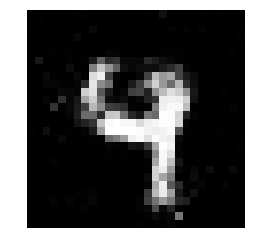

In [49]:
import matplotlib.pyplot as plt
noise = np.random.normal(0, 1, (1, 100))
imgs_p = obj.predict(noise)
plt.imshow(imgs_p.reshape((28,28)), cmap="gray")
plt.axis("off")